In [1]:
# เริ่มต้นใช้งาน GEE
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [2]:
import folium

# กำหนดพื้นที่ศึกษา เชียงใหม่
# siteName = 'Mae Hong Son'
siteName = 'Chiang Mai'
# siteName = 'Nan'
# siteName = 'Uttaradit'
study_area = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Thailand')).filter(ee.Filter.eq('ADM1_NAME', siteName))

# config figure height
f = folium.Figure(height=300)

# add map to figure
m = folium.Map(location=[18.9, 99.0], zoom_start=7).add_to(f)

# add study area to map
folium.GeoJson(study_area.getInfo()).add_to(m)

m

In [3]:
# Comprehensive Model Evaluation with Baseline Models and Prediction Intervals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

try:
    import statsmodels.api as sm
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.tsa.stattools import adfuller
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("Warning: statsmodels ไม่พร้อมใช้งาน บาง baseline models จะไม่ทำงาน")

try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
except ImportError:
    PMDARIMA_AVAILABLE = False
    print("Warning: pmdarima ไม่พร้อมใช้งาน Auto-ARIMA จะไม่ทำงาน")

def get_monthly_hotspots(start_date, end_date, study_area, temp_min=310, temp_max=320, all_hotspots=False):
    """
    ดึงข้อมูล hotspot รายเดือนด้วยการกรองอุณหภูมิ T21 ในช่วงที่กำหนด
    
    Parameters:
    - start_date, end_date: ช่วงวันที่
    - study_area: พื้นที่ศึกษา
    - temp_min: อุณหภูมิต่ำสุด (Kelvin) - default 310
    - temp_max: อุณหภูมิสูงสุด (Kelvin) - default 320
    - all_hotspots: ถ้า True ใช้เกณฑ์ T21 > 0 แทนการกรอง min-max
    """
    try:
        # เรียกชุดข้อมูล FIRMS
        firms = ee.ImageCollection('FIRMS') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)

        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = firms.size().getInfo()
        print(f"จำนวนภาพ FIRMS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล FIRMS ในพื้นที่ศึกษา")
            return None

        if all_hotspots:
            print("ใช้เกณฑ์: ทุกจุดความร้อน (T21 > 0)")
        else:
            print(f"ใช้เกณฑ์อุณหภูมิ: {temp_min}K ≤ T21 < {temp_max}K")

        # Apply temperature filter for T21
        def convert_to_filtered_presence(image):
            t21 = image.select('T21')
            if all_hotspots:
                hotspot_presence = t21.gt(0).rename('hotspot_presence')
            else:
                hotspot_presence = t21.gte(temp_min).And(t21.lt(temp_max)).rename('hotspot_presence')
            return image.addBands(hotspot_presence).copyProperties(image, ['system:time_start'])

        firms_with_presence = firms.map(convert_to_filtered_presence)

        # รวม hotspot เป็นรายเดือน
        def create_monthly_hotspot_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            monthly_collection = firms_with_presence.filterDate(start, end)
            count = monthly_collection.size()

            def process_with_data():
                monthly_sum = monthly_collection.select('hotspot_presence').sum()
                reduction = monthly_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                )
                hotspot_count = ee.Number(reduction.get('hotspot_presence'))
                hotspot_count = ee.Algorithms.If(hotspot_count, hotspot_count, ee.Number(0))

                return ee.Image.constant(hotspot_count).toFloat().rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month) \
                    .set('temp_filter_min', temp_min) \
                    .set('temp_filter_max', temp_max) \
                    .set('hotspot_count_prop', hotspot_count)

            def process_without_data():
                return ee.Image.constant(0).toFloat().rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month) \
                    .set('temp_filter_min', temp_min) \
                    .set('temp_filter_max', temp_max) \
                    .set('hotspot_count_prop', ee.Number(0))

            return ee.Algorithms.If(count.gt(0), process_with_data(), process_without_data())

        # สร้างรายการปี-เดือน
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []
        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])
            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)

        year_months_ee = ee.List(year_months)
        monthly_images = year_months_ee.map(create_monthly_hotspot_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)

        total_months = monthly_composites.size().getInfo()
        print(f"จำนวนเดือนทั้งหมด: {total_months}")

        return monthly_composites.select(['hotspot_count'])
        
    except Exception as e:
        print(f"Error getting monthly hotspots: {e}")
        return None


# Updated create_monthly_dataset function to use separate NDVI and hotspot data
def create_monthly_dataset_with_filtered_hotspots(ndvi_collection, hotspot_collection, study_area):
    """
    สร้างข้อมูลรวมรายเดือนจาก NDVI และ hotspot ที่กรองแล้ว
    """
    try:
        if ndvi_collection is None or hotspot_collection is None:
            print("ข้อมูล NDVI หรือ hotspot เป็น None")
            return None

        ndvi_size = ndvi_collection.size().getInfo()
        hotspot_size = hotspot_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")
        print(f"Hotspot collection size: {hotspot_size}")

        if ndvi_size == 0 or hotspot_size == 0:
            print("ไม่มีข้อมูล NDVI หรือ hotspot")
            return None

        # รวม NDVI และ hotspot โดยใช้ time_start
        def join_ndvi_hotspot(ndvi_image):
            time_start = ndvi_image.get('system:time_start')
            
            # หา hotspot image ที่มี time_start เดียวกัน
            hotspot_match = hotspot_collection.filter(
                ee.Filter.eq('system:time_start', time_start)
            ).first()
            
            # รวม bands
            combined = ndvi_image.addBands(
                ee.Algorithms.If(
                    hotspot_match,
                    hotspot_match.select('hotspot_count'),
                    ee.Image.constant(0).rename('hotspot_count')
                )
            )
            
            return combined

        # รวมข้อมูล NDVI และ hotspot
        combined_collection = ndvi_collection.map(join_ndvi_hotspot)
        
        # ลดขนาดข้อมูลเป็นค่าเฉลี่ยของพื้นที่ศึกษา
        def reduce_to_features(image):
            reduced = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,
                maxPixels=1e9
            )
            
            # สร้าง Feature พร้อมวันที่
            date_str = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
            year = ee.Date(image.get('system:time_start')).get('year')
            month = ee.Date(image.get('system:time_start')).get('month')
            
            properties = reduced.combine({
                'date': date_str,
                'year': year,
                'month': month
            })
            
            return ee.Feature(None, properties)

        # แปลงเป็น FeatureCollection
        feature_collection = combined_collection.map(reduce_to_features)
        
        return feature_collection

    except Exception as e:
        print(f"Error creating combined monthly dataset: {e}")
        return None

# ฟังก์ชันคำนวณ NDVI จาก MOD09Q1
def calculate_ndvi(image):
    try:
        # MOD09Q1 bands: sur_refl_b01 (red), sur_refl_b02 (NIR)
        nir = image.select('sur_refl_b02').multiply(0.0001)  # Apply scale factor
        red = image.select('sur_refl_b01').multiply(0.0001)  # Apply scale factor

        # คำนวณ NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

        # กำหนดคุณสมบัติให้กับภาพ
        return image.addBands(ndvi).copyProperties(image, ['system:time_start'])
    except Exception as e:
        print(f"Error calculating NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล NDVI รายเดือนจาก MOD09Q1
def get_monthly_ndvi(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล MOD09Q1
        modis = ee.ImageCollection('MODIS/061/MOD09Q1') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)

        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = modis.size().getInfo()
        print(f"จำนวนภาพ MODIS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล MOD09Q1 ในพื้นที่ศึกษา")
            return None

        # คำนวณ NDVI
        modis_ndvi = modis.map(calculate_ndvi)
        print(f"จำนวนภาพหลังคำนวณ NDVI: {modis_ndvi.size().getInfo()}")

        # เฉลี่ย NDVI เป็นรายเดือน
        def create_monthly_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()

            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            monthly_collection = modis_ndvi.filterDate(start, end)
            count = monthly_collection.size()

            # สร้างภาพเฉลี่ยรายเดือน
            monthly_mean = monthly_collection.mean() \
                .set('system:time_start', start.millis()) \
                .set('system:index', start.format('YYYY_MM')) \
                .set('year', year) \
                .set('month', month)

            return ee.Algorithms.If(
                count.gt(0),
                monthly_mean,
                ee.Image.constant(0).rename('NDVI') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month)
            )

        # สร้างรายการปี-เดือน
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []

        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])

            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)

        year_months_ee = ee.List(year_months)

        # สร้าง ImageCollection
        monthly_images = year_months_ee.map(create_monthly_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)

        print(f"จำนวนเดือนทั้งหมด: {monthly_composites.size().getInfo()}")

        return monthly_composites.select('NDVI')
    except Exception as e:
        print(f"Error getting monthly NDVI: {e}")
        return None

# ฟังก์ชันสร้างข้อมูลรวมรายเดือน - FIXED VERSION
def create_monthly_dataset(ndvi_collection, study_area):
    try:
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        if ndvi_collection is None:
            print("ข้อมูล NDVI เป็น None")
            return None

        ndvi_size = ndvi_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")

        if ndvi_size == 0:
            print("ไม่มีข้อมูล NDVI")
            return None

        # ใช้วันที่ของ NDVI เป็นหลัก
        ndvi_times = ndvi_collection.aggregate_array('system:time_start')
        print(f"จำนวนเดือนที่มีข้อมูล NDVI: {ndvi_times.size().getInfo()}")

        # ฟังก์ชันสำหรับรวมข้อมูลแต่ละเดือน - FIXED to avoid client-side operations
        def combine_monthly_data(time_start):
            # กรองข้อมูล NDVI ตามเวลา
            ndvi_image = ndvi_collection.filter(ee.Filter.eq('system:time_start', time_start)).first()

            # หา hotspot ในเดือนเดียวกับ NDVI
            start_date = ee.Date(time_start)
            end_date = start_date.advance(1, 'month')

            # ดึงข้อมูล FIRMS ในช่วงเวลาเดียวกับ NDVI
            firms_in_period = ee.ImageCollection('FIRMS') \
                .filterDate(start_date, end_date) \
                .filterBounds(study_area)

            # 4. Change T21 to count hotspot - Convert to hotspot count
            def count_hotspots(image):
                return image.select('T21').gt(0).rename('hotspot_presence')

            hotspot_presence = firms_in_period.map(count_hotspots)

            # Sum hotspots spatially and temporally - FIXED to avoid client-side .getInfo()
            monthly_hotspot_sum = hotspot_presence.sum()

            # Use ee.Algorithms.If to handle empty collections without client-side operations
            has_hotspots = hotspot_presence.size().gt(0)

            hotspot_count_reduced = ee.Algorithms.If(
                has_hotspots,
                monthly_hotspot_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                ).get('hotspot_presence'),
                0
            )

            # Create hotspot count image
            hotspot_count_image = ee.Image.constant(hotspot_count_reduced).rename('hotspot_count')

            # รวมภาพ
            combined_image = ndvi_image.addBands(hotspot_count_image)

            # ลดขนาดข้อมูลเป็นค่าเฉลี่ยของพื้นที่ศึกษา
            reduced = combined_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,  # 1km resolution
                maxPixels=1e9
            )

            # สร้าง Feature พร้อมวันที่
            date_str = start_date.format('YYYY-MM-dd')
            year = start_date.get('year')
            month = start_date.get('month')

            # Create properties dictionary properly
            properties = reduced.combine({
                'date': date_str,
                'year': year,
                'month': month
            })

            return ee.Feature(None, properties)

        # แปลงเป็น FeatureCollection โดยใช้เวลาของ NDVI
        ndvi_times_size = ndvi_times.size().getInfo()
        if ndvi_times_size > 0:
            combined_fc = ee.FeatureCollection(ndvi_times.map(combine_monthly_data))
            return combined_fc
        else:
            print("ไม่มีข้อมูล NDVI")
            return None

    except Exception as e:
        print(f"Error creating monthly dataset: {e}")
        return None

# ฟังก์ชันแปลง FeatureCollection เป็น DataFrame
def fc_to_df(fc):
    try:
        # ดึงข้อมูลจาก GEE
        features = fc.getInfo()['features']
    except Exception as e:
        print("ไม่สามารถดึงข้อมูลจาก GEE ได้:", str(e))
        return pd.DataFrame()

    # สร้าง dictionary สำหรับเก็บข้อมูล - Updated to use hotspot_count
    data_dict = {'date': [], 'NDVI': [], 'hotspot_count': [], 'year': [], 'month': []}

    for feature in features:
        props = feature['properties']
        if 'NDVI' in props and props['NDVI'] is not None:
            data_dict['date'].append(props.get('date', ''))
            data_dict['NDVI'].append(props.get('NDVI', 0))
            data_dict['hotspot_count'].append(props.get('hotspot_count', 0))
            data_dict['year'].append(props.get('year', 0))
            data_dict['month'].append(props.get('month', 0))

    # สร้าง DataFrame
    df = pd.DataFrame(data_dict)

    # แปลงคอลัมน์ date เป็น datetime
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)

    return df

# ฟังก์ชันสร้างแบบจำลอง LSTM สำหรับรายเดือน
def create_monthly_lstm_model(sequence_length, n_features):
    """สร้างแบบจำลอง LSTM สำหรับทำนาย hotspot รายเดือน"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.regularizers import l2

        model = Sequential()

        # LSTM layers with regularization
        model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features),
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

        model.add(LSTM(32, return_sequences=True,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

        model.add(LSTM(16, return_sequences=False,
                      kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))

        # Dense layers
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))

        # Output layer
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='mse',
                      metrics=['mae'])

        return model
    except ImportError:
        print("ไม่สามารถ import TensorFlow ได้ กรุณาติดตั้ง TensorFlow ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแบบจำลอง: {e}")
        return None

# 5. Add learning curve chart
def plot_learning_curve(history):
    """สร้างกราฟ Learning Curve"""
    try:
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss curve
        ax1.plot(history.history['loss'], label='Training Loss', color='blue')
        if 'val_loss' in history.history:
            ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
        ax1.set_title(f'Model Loss Learning Curve ({siteName})', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss (MSE)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # MAE curve
        ax2.plot(history.history['mae'], label='Training MAE', color='blue')
        if 'val_mae' in history.history:
            ax2.plot(history.history['val_mae'], label='Validation MAE', color='red')
        ax2.set_title(f'Model MAE Learning Curve ({siteName})', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Mean Absolute Error')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        # plt.savefig(f'{siteName}_learning_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟ Learning Curve: learning_curve.png")

    except ImportError:
        print("ไม่สามารถ import matplotlib ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ Learning Curve: {e}")

# 6. Add actual vs predict chart
def plot_actual_vs_predicted(y_true, y_pred, target_column='hotspot_count'):
    """สร้างกราฟ Actual vs Predicted"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Scatter plot
        ax1.scatter(y_true, y_pred, alpha=0.6, color='blue')

        # Perfect prediction line
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        ax1.set_xlabel(f'Actual {target_column}')
        ax1.set_ylabel(f'Predicted {target_column}')
        ax1.set_title(f'Actual vs Predicted {target_column} ({siteName})\nR² = {r2:.3f}, MAE = {mae:.3f}, RMSE = {rmse:.3f}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Residual plot
        residuals = y_true - y_pred
        ax2.scatter(y_pred, residuals, alpha=0.6, color='green')
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_xlabel(f'Predicted {target_column}')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residual Plot')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        # plt.savefig(f'{siteName}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("บันทึกกราฟ Actual vs Predicted: actual_vs_predicted.png")

        return r2, mae, rmse

    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
        return None, None, None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ Actual vs Predicted: {e}")
        return None, None, None

# ฟังก์ชันระบบฤดูกาลแบบเอเชีย
def get_asian_season(month):
    """แบ่งฤดูกาลตามภูมิอากาศเอเชีย (ไทย)"""
    if month in [3, 4, 5]:
        return 'Summer'  # ฤดูร้อน
    elif month in [6, 7, 8, 9, 10]:
        return 'Rainy'   # ฤดูฝน
    else:  # month in [11, 12, 1, 2]
        return 'Winter'  # ฤดูหนาว

def get_asian_season_thai(month):
    """เวอร์ชันภาษาไทย"""
    if month in [3, 4, 5]:
        return 'ฤดูร้อน'
    elif month in [6, 7, 8, 9, 10]:
        return 'ฤดูฝน'
    else:
        return 'ฤดูหนาว'

def get_asian_season_number(month):
    """แปลงฤดูกาลเป็นตัวเลข สำหรับการคำนวณ"""
    if month in [3, 4, 5]:
        return 1  # Summer
    elif month in [6, 7, 8, 9, 10]:
        return 2  # Rainy
    else:
        return 3  # Winter

# 2. แทนที่ฟังก์ชัน add_seasonal_features เดิม
def add_seasonal_features(df):
    """เพิ่ม features สำหรับฤดูกาลแบบเอเชีย"""
    
    # Monthly cyclical encoding (เดิม)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Asian seasonal features - Binary encoding
    df['summer_season'] = (df['month'].isin([3, 4, 5])).astype(int)      # มีนาคม-พฤษภาคม
    df['rainy_season'] = (df['month'].isin([6, 7, 8, 9, 10])).astype(int)  # มิถุนายน-ตุลาคม
    df['winter_season'] = (df['month'].isin([11, 12, 1, 2])).astype(int)   # พฤศจิกายน-กุมภาพันธ์
    
    # Asian seasonal cyclical encoding (3 seasons instead of 4)
    df['season_number'] = df['month'].apply(get_asian_season_number)
    df['season_sin'] = np.sin(2 * np.pi * df['season_number'] / 3)
    df['season_cos'] = np.cos(2 * np.pi * df['season_number'] / 3)
    
    # Add season names for analysis
    df['season_name'] = df['month'].apply(get_asian_season)
    df['season_name_thai'] = df['month'].apply(get_asian_season_thai)
    
    # Fire season indicators (specific to Thailand fire patterns)
    df['peak_fire_season'] = (df['month'].isin([2, 3, 4])).astype(int)  # Peak fire season
    df['low_fire_season'] = (df['month'].isin([6, 7, 8, 9])).astype(int)  # Low fire season
    
    return df

# 3. แทนที่ฟังก์ชัน prepare_monthly_training_data เดิม
def prepare_monthly_training_data(df, sequence_length=6, target_column='hotspot_count'):
    """เตรียมข้อมูลสำหรับการสร้างแบบจำลองด้วยระบบฤดูกาลแบบเอเชีย"""
    
    if df.empty:
        raise ValueError("ไม่มีข้อมูลใน DataFrame")

    print(f"จำนวนข้อมูลดิบ: {len(df)}")
    print(f"คอลัมน์ที่มี: {df.columns.tolist()}")
    print(f"ตัวอย่างข้อมูล:\n{df.head()}")

    # เพิ่ม seasonal features แบบเอเชีย
    df = add_seasonal_features(df)

    # ล้างข้อมูลที่ขาดหาย
    df_cleaned = df.fillna(0)
    print(f"จำนวนข้อมูลหลังล้าง: {len(df_cleaned)}")
    print(f"ค่าสถิติพื้นฐาน:\n{df_cleaned.describe()}")

    # ตรวจสอบว่ามีข้อมูลเพียงพอ
    min_required = sequence_length + 5
    if len(df_cleaned) < min_required:
        raise ValueError(f"ข้อมูลไม่เพียงพอสำหรับการสร้างลำดับ ต้องการอย่างน้อย {min_required} ข้อมูล แต่มีเพียง {len(df_cleaned)}")

    # เตรียมข้อมูล feature และ target - ใช้ features แบบเอเชีย
    feature_columns = [
        'NDVI', 
        'month_sin', 'month_cos',           # Monthly cyclical
        'season_sin', 'season_cos',         # Asian seasonal cyclical
        'summer_season', 'rainy_season', 'winter_season',  # Asian seasonal binary
        'peak_fire_season', 'low_fire_season'  # Fire season specific
    ]

    # ตรวจสอบว่า target column มีอยู่
    if target_column not in df_cleaned.columns:
        target_column = 'hotspot_count'
        print(f"ใช้ {target_column} เป็น target variable")

    X = df_cleaned[feature_columns].values
    y = df_cleaned[[target_column]].values

    print(f"Features ที่ใช้: {feature_columns}")
    print(f"Target ที่ใช้: {target_column}")
    print(f"รูปร่างข้อมูล: X = {X.shape}, y = {y.shape}")

    # ปรับขนาดข้อมูล
    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # สร้างลำดับข้อมูลสำหรับ LSTM
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    print(f"จำนวนลำดับที่สร้างได้: {len(X_seq)}")
    print(f"รูปร่างข้อมูล X: {X_seq.shape}, y: {y_seq.shape}")

    return X_seq, y_seq, scaler_x, scaler_y, df_cleaned

# 4. แทนที่ฟังก์ชัน predict_next_12_months เดิม
def predict_next_12_months(model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6):
    """ทำนายค่า hotspot สำหรับ 12 เดือนถัดไปด้วยระบบฤดูกาลแบบเอเชีย"""

    predictions = []
    prediction_dates = []
    current_sequence = last_sequence.copy()

    # หาวันที่สุดท้ายในข้อมูล
    last_date = df_cleaned['date'].iloc[-1]

    for month_ahead in range(1, 13):
        # ทำนายเดือนถัดไป
        pred_scaled = model.predict(current_sequence, verbose=0)
        pred_original = scaler_y.inverse_transform(pred_scaled)
        predictions.append(pred_original[0][0])

        # คำนวณวันที่ของเดือนถัดไป
        if last_date.month == 12:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1
        else:
            next_year = last_date.year + (last_date.month + month_ahead - 1) // 12
            next_month = ((last_date.month + month_ahead - 1) % 12) + 1

        if next_month > 12:
            next_year += 1
            next_month = next_month - 12

        prediction_date = datetime(next_year, next_month, 1)
        prediction_dates.append(prediction_date)

        # สร้าง features สำหรับเดือนถัดไป - ใช้ระบบฤดูกาลแบบเอเชีย
        month_sin = np.sin(2 * np.pi * next_month / 12)
        month_cos = np.cos(2 * np.pi * next_month / 12)
        
        # Asian seasonal features
        season_number = get_asian_season_number(next_month)
        season_sin = np.sin(2 * np.pi * season_number / 3)
        season_cos = np.cos(2 * np.pi * season_number / 3)
        
        summer_season = 1 if next_month in [3, 4, 5] else 0
        rainy_season = 1 if next_month in [6, 7, 8, 9, 10] else 0
        winter_season = 1 if next_month in [11, 12, 1, 2] else 0
        
        peak_fire_season = 1 if next_month in [2, 3, 4] else 0
        low_fire_season = 1 if next_month in [6, 7, 8, 9] else 0

        # สมมติค่า NDVI
        same_month_data = df_cleaned[df_cleaned['month'] == next_month]
        if not same_month_data.empty:
            avg_ndvi = same_month_data['NDVI'].mean()
        else:
            avg_ndvi = df_cleaned['NDVI'].mean()

        # สร้าง feature vector สำหรับเดือนถัดไป
        next_features = np.array([[
            avg_ndvi, month_sin, month_cos, season_sin, season_cos,
            summer_season, rainy_season, winter_season, 
            peak_fire_season, low_fire_season
        ]])

        # ปรับขนาดข้อมูล
        next_features_scaled = scaler_x.transform(next_features)

        # อัพเดท sequence สำหรับการทำนายครั้งถัดไป
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = next_features_scaled[0]

    return predictions, prediction_dates

# ฟังก์ชันสร้างตารางสรุปการทำนาย 12 เดือน - Updated for hotspot_count
def create_prediction_summary_table(predictions, prediction_dates, target_column='hotspot_count'):
    """สร้างตารางสรุปการทำนาย"""
    try:
        # สร้าง DataFrame สำหรับการทำนาย
        pred_df = pd.DataFrame({
            'Date': prediction_dates,
            'Month': [calendar.month_name[date.month] for date in prediction_dates],
            'Year': [date.year for date in prediction_dates],
            f'Predicted_{target_column}': predictions
        })

        # เพิ่มคอลัมน์ Risk Level - Updated thresholds for hotspot count
        def get_risk_level(value):
            if value > 50:  # Adjusted for hotspot count
                return 'High Risk'
            elif value > 25:  # Adjusted for hotspot count
                return 'Medium Risk'
            else:
                return 'Low Risk'

        pred_df['Risk_Level'] = pred_df[f'Predicted_{target_column}'].apply(get_risk_level)

        # เพิ่มคอลัมน์ฤดู
        def get_season(month):
            if month in [6, 7, 8, 9, 10]:
                return 'Rainy'
            elif month in [11, 12, 1, 2]:
                return 'Winter'
            else:  # month in [3, 4, 5]
                return 'Summer'

        pred_df['Season'] = pred_df['Month'].apply(get_season)

        # จัดรูปแบบตาราง
        pred_df[f'Predicted_{target_column}'] = pred_df[f'Predicted_{target_column}'].round(0)

        print("\n" + "="*80)
        print("สรุปการทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า")
        print("="*80)
        print(pred_df.to_string(index=False))

        # สถิติสรุป
        print("\n" + "="*50)
        print("สถิติสรุป")
        print("="*50)
        print(f"ค่าเฉลี่ย: {pred_df[f'Predicted_{target_column}'].mean():.0f} hotspots")
        print(f"ค่าสูงสุด: {pred_df[f'Predicted_{target_column}'].max():.0f} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmax(), 'Month']})")
        print(f"ค่าต่ำสุด: {pred_df[f'Predicted_{target_column}'].min():.0f} hotspots ({pred_df.loc[pred_df[f'Predicted_{target_column}'].idxmin(), 'Month']})")

        # สรุปตามระดับความเสี่ยง
        risk_summary = pred_df['Risk_Level'].value_counts()
        print(f"\nสรุปตามระดับความเสี่ยง:")
        for risk, count in risk_summary.items():
            print(f"  {risk}: {count} เดือน ({count/12*100:.1f}%)")

        # สรุปตามฤดู
        season_summary = pred_df.groupby('Season')[f'Predicted_{target_column}'].agg(['mean', 'max', 'min'])
        print(f"\nสรุปตามฤดู:")
        for season in season_summary.index:
            print(f"  {season}:")
            print(f"    ค่าเฉลี่ย: {season_summary.loc[season, 'mean']:.0f} hotspots")
            print(f"    ค่าสูงสุด: {season_summary.loc[season, 'max']:.0f} hotspots")
            print(f"    ค่าต่ำสุด: {season_summary.loc[season, 'min']:.0f} hotspots")

        # บันทึกตารางเป็นไฟล์ CSV
        # pred_df.to_csv(f'{siteName}_12_month_hotspot_predictions.csv', index=False)
        # print(f"\nบันทึกตารางการทำนาย: {siteName}_12_month_hotspot_predictions.csv")

        return pred_df

    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างตารางสรุป: {e}")
        return None

def plot_ndvi_hotspot_time_series(df, save_plot=True):
    """
    Create comprehensive time series plots showing NDVI vs Hotspot count relationship
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from datetime import datetime
        import numpy as np

        # Set style for better looking plots
        plt.style.use('default')
        sns.set_palette("husl")

        # Create figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))

        # 1. Main time series plot with dual y-axes
        ax1 = plt.subplot(3, 2, (1, 2))  # Top row, spans 2 columns

        # Plot NDVI on primary y-axis
        line1 = ax1.plot(df['date'], df['NDVI'],
                        color='green', linewidth=2, marker='o', markersize=4,
                        label='NDVI', alpha=0.8)
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('NDVI', fontsize=12, color='green')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.grid(True, alpha=0.3)

        # Create secondary y-axis for hotspot count
        ax2 = ax1.twinx()
        line2 = ax2.plot(df['date'], df['hotspot_count'],
                        color='red', linewidth=2, marker='s', markersize=4,
                        label='Hotspot Count', alpha=0.8)
        ax2.set_ylabel('Hotspot Count', fontsize=12, color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Add correlation coefficient to title
        correlation = df['NDVI'].corr(df['hotspot_count'])
        ax1.set_title(f'NDVI vs Hotspot Count Time Series ({siteName})\nCorrelation: {correlation:.3f}',
                     fontsize=16, fontweight='bold', pad=20)

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=10)

        # Rotate x-axis labels for better readability
        ax1.tick_params(axis='x', rotation=45)

        # 2. Scatter plot showing correlation
        ax3 = plt.subplot(3, 2, 3)
        scatter = ax3.scatter(df['NDVI'], df['hotspot_count'],
                             c=df.index, cmap='viridis', alpha=0.6, s=50)
        ax3.set_xlabel('NDVI', fontsize=12)
        ax3.set_ylabel('Hotspot Count', fontsize=12)
        ax3.set_title(f'NDVI vs Hotspot Count Scatter Plot ({siteName})', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(df['NDVI'], df['hotspot_count'], 1)
        p = np.poly1d(z)
        ax3.plot(df['NDVI'], p(df['NDVI']), "r--", alpha=0.8, linewidth=2)

        # Add colorbar for time progression
        cbar = plt.colorbar(scatter, ax=ax3)
        cbar.set_label('Time Progression', fontsize=10)

        # 3. Monthly averages comparison
        ax4 = plt.subplot(3, 2, 4)
        monthly_avg = df.groupby('month').agg({
            'NDVI': 'mean',
            'hotspot_count': 'mean'
        }).reset_index()

        # Create month names
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        monthly_avg['month_name'] = [month_names[i-1] for i in monthly_avg['month']]

        ax4_twin = ax4.twinx()

        bars1 = ax4.bar([x - 0.2 for x in range(len(monthly_avg))], monthly_avg['NDVI'],
                       width=0.4, color='green', alpha=0.7, label='NDVI')
        bars2 = ax4_twin.bar([x + 0.2 for x in range(len(monthly_avg))], monthly_avg['hotspot_count'],
                            width=0.4, color='red', alpha=0.7, label='Hotspot Count')

        ax4.set_xlabel('Month', fontsize=12)
        ax4.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax4_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax4.set_title(f'Monthly Averages Comparison ({siteName})', fontsize=14, fontweight='bold')

        ax4.set_xticks(range(len(monthly_avg)))
        ax4.set_xticklabels(monthly_avg['month_name'], rotation=45)
        ax4.tick_params(axis='y', labelcolor='green')
        ax4_twin.tick_params(axis='y', labelcolor='red')

        # Add legends
        ax4.legend(loc='upper left')
        ax4_twin.legend(loc='upper right')

        # 4. Seasonal analysis
        ax5 = plt.subplot(3, 2, 5)

        # Define seasons
        def get_season_name(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Autumn'

        df['season'] = df['month'].apply(get_season_name)
        seasonal_stats = df.groupby('season').agg({
            'NDVI': ['mean', 'std'],
            'hotspot_count': ['mean', 'std']
        }).round(3)

        seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
        ndvi_means = [seasonal_stats.loc[s, ('NDVI', 'mean')] for s in seasons]
        ndvi_stds = [seasonal_stats.loc[s, ('NDVI', 'std')] for s in seasons]
        hotspot_means = [seasonal_stats.loc[s, ('hotspot_count', 'mean')] for s in seasons]
        hotspot_stds = [seasonal_stats.loc[s, ('hotspot_count', 'std')] for s in seasons]

        x_pos = np.arange(len(seasons))

        ax5_twin = ax5.twinx()

        bars1 = ax5.bar(x_pos - 0.2, ndvi_means, 0.4, yerr=ndvi_stds,
                       color='green', alpha=0.7, capsize=5, label='NDVI')
        bars2 = ax5_twin.bar(x_pos + 0.2, hotspot_means, 0.4, yerr=hotspot_stds,
                            color='red', alpha=0.7, capsize=5, label='Hotspot Count')

        ax5.set_xlabel('Season', fontsize=12)
        ax5.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax5_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax5.set_title(f'Seasonal Analysis with Standard Deviation ({siteName})', fontsize=14, fontweight='bold')
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels(seasons)
        ax5.tick_params(axis='y', labelcolor='green')
        ax5_twin.tick_params(axis='y', labelcolor='red')

        ax5.legend(loc='upper left')
        ax5_twin.legend(loc='upper right')

        # 5. Moving averages
        ax6 = plt.subplot(3, 2, 6)

        # Calculate moving averages
        window = 6  # 6-month moving average
        df['NDVI_ma'] = df['NDVI'].rolling(window=window, center=True).mean()
        df['hotspot_ma'] = df['hotspot_count'].rolling(window=window, center=True).mean()

        line1 = ax6.plot(df['date'], df['NDVI_ma'],
                        color='darkgreen', linewidth=3, label=f'NDVI {window}-month MA')

        ax6_twin = ax6.twinx()
        line2 = ax6_twin.plot(df['date'], df['hotspot_ma'],
                             color='darkred', linewidth=3, label=f'Hotspot {window}-month MA')

        ax6.set_xlabel('Date', fontsize=12)
        ax6.set_ylabel('NDVI Moving Average', fontsize=12, color='darkgreen')
        ax6_twin.set_ylabel('Hotspot Moving Average', fontsize=12, color='darkred')
        ax6.set_title(f'{window}-Month Moving Averages ({siteName})', fontsize=14, fontweight='bold')
        ax6.tick_params(axis='x', rotation=45)
        ax6.tick_params(axis='y', labelcolor='darkgreen')
        ax6_twin.tick_params(axis='y', labelcolor='darkred')
        ax6.grid(True, alpha=0.3)

        ax6.legend(loc='upper left')
        ax6_twin.legend(loc='upper right')

        plt.tight_layout()

        if save_plot:
            # plt.savefig(f'{siteName}_ndvi_hotspot_time_series_analysis.png', dpi=300, bbox_inches='tight')
            print(f"บันทึกกราฟ NDVI vs Hotspot Time Series: {siteName}_ndvi_hotspot_time_series_analysis.png")

        plt.show()

        # Print correlation analysis
        print("\n" + "="*60)
        print("การวิเคราะห์ความสัมพันธ์ NDVI vs Hotspot Count")
        print("="*60)
        print(f"Pearson Correlation: {correlation:.4f}")

        # Lag correlation analysis
        print("\nLag Correlation Analysis:")
        for lag in range(1, 7):
            lag_corr = df['NDVI'].corr(df['hotspot_count'].shift(lag))
            print(f"NDVI vs Hotspot (lag {lag} months): {lag_corr:.4f}")

        # Seasonal correlation
        print(f"\nSeasonal Correlations:")
        for season in seasons:
            season_data = df[df['season'] == season]
            if len(season_data) > 1:
                season_corr = season_data['NDVI'].corr(season_data['hotspot_count'])
                print(f"{season}: {season_corr:.4f}")

        return fig

    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ time series: {e}")


def plot_yearly_comparison(df, save_plot=True):
    """
    Create yearly comparison plots for NDVI and Hotspot trends
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Extract year from date
        df['year'] = df['date'].dt.year
        years = sorted(df['year'].unique())

        fig, ((ax3, ax2), (ax1, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

        # 1. Yearly averages line plot
        yearly_avg = df.groupby('year').agg({
            'NDVI': 'mean',
            'hotspot_count': 'mean'
        }).reset_index()

        ax1_twin = ax1.twinx()

        line1 = ax1.plot(yearly_avg['year'], yearly_avg['NDVI'],
                        color='green', marker='o', linewidth=3, markersize=8, label='NDVI')
        line2 = ax1_twin.plot(yearly_avg['year'], yearly_avg['hotspot_count'],
                             color='red', marker='s', linewidth=3, markersize=8, label='Hotspot Count')

        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Average NDVI', fontsize=12, color='green')
        ax1_twin.set_ylabel('Average Hotspot Count', fontsize=12, color='red')
        ax1.set_title(f'Yearly Averages Trend ({siteName})', fontsize=14, fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1_twin.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, alpha=0.3)

        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')

        # 2. Heatmap of monthly values by year for NDVI
        pivot_ndvi = df.pivot_table(values='NDVI', index='year', columns='month', aggfunc='mean')
        sns.heatmap(pivot_ndvi, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'NDVI'})
        ax2.set_title(f'NDVI Monthly Heatmap by Year ({siteName})', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel('Year', fontsize=12)

        # 3. Heatmap of monthly values by year for Hotspot Count
        pivot_hotspot = df.pivot_table(values='hotspot_count', index='year', columns='month', aggfunc='mean')
        sns.heatmap(pivot_hotspot, annot=True, fmt='.1f', cmap='Reds', ax=ax3, cbar_kws={'label': 'Hotspot Count'})
        ax3.set_title(f'Hotspot Count Monthly Heatmap by Year ({siteName})', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Month', fontsize=12)
        ax3.set_ylabel('Year', fontsize=12)

        # 4. Box plots for distribution comparison
        years_to_plot = years[-5:] if len(years) > 5 else years  # Last 5 years or all if less

        df_recent = df[df['year'].isin(years_to_plot)]

        ax4_twin = ax4.twinx()

        # NDVI box plot
        ndvi_data = [df_recent[df_recent['year'] == year]['NDVI'].values for year in years_to_plot]
        bp1 = ax4.boxplot(ndvi_data, positions=[x - 0.2 for x in range(len(years_to_plot))],
                         widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightgreen'))

        # Hotspot box plot
        hotspot_data = [df_recent[df_recent['year'] == year]['hotspot_count'].values for year in years_to_plot]
        bp2 = ax4_twin.boxplot(hotspot_data, positions=[x + 0.2 for x in range(len(years_to_plot))],
                              widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightcoral'))

        ax4.set_xlabel('Year', fontsize=12)
        ax4.set_ylabel('NDVI Distribution', fontsize=12, color='green')
        ax4_twin.set_ylabel('Hotspot Count Distribution', fontsize=12, color='red')
        ax4.set_title(f'Distribution Comparison (Last {len(years_to_plot)} Years) ({siteName})', fontsize=14, fontweight='bold')
        ax4.set_xticks(range(len(years_to_plot)))
        ax4.set_xticklabels(years_to_plot)
        ax4.tick_params(axis='y', labelcolor='green')
        ax4_twin.tick_params(axis='y', labelcolor='red')

        # Add legend for box plots
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='lightgreen', label='NDVI'),
                          Patch(facecolor='lightcoral', label='Hotspot Count')]
        ax4.legend(handles=legend_elements, loc='upper left')

        plt.tight_layout()

        if save_plot:
            # plt.savefig(f'{siteName}_yearly_comparison_analysis.png', dpi=300, bbox_inches='tight')
            print(f"บันทึกกราฟ Yearly Comparison: {siteName}_yearly_comparison_analysis.png")

        plt.show()

        return fig

    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟ yearly comparison: {e}")


def create_comprehensive_analysis_report(df, save_report=True):
    """
    Create a comprehensive statistical report of NDVI vs Hotspot relationship
    """
    try:
        import pandas as pd
        import numpy as np
        from scipy import stats

        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS REPORT: NDVI vs HOTSPOT COUNT")
        print("="*80)

        # Basic statistics
        print("\n1. BASIC STATISTICS")
        print("-" * 40)
        stats_df = df[['NDVI', 'hotspot_count']].describe()
        print(stats_df)

        # Correlation analysis
        print("\n2. CORRELATION ANALYSIS")
        print("-" * 40)
        correlation_matrix = df[['NDVI', 'hotspot_count', 'month', 'year']].corr()
        print("Correlation Matrix:")
        print(correlation_matrix)

        # Statistical significance test
        corr_coef, p_value = stats.pearsonr(df['NDVI'], df['hotspot_count'])
        print(f"\nPearson Correlation Coefficient: {corr_coef:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Statistical Significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")

        # Seasonal analysis - แก้ไขให้ใช้ SEA climate
        print("\n3. SEASONAL ANALYSIS (SEA Climate)")
        print("-" * 40)

        # Define SEA seasons - ปรับให้เหมาะกับเอเชียตะวันออกเฉียงใต้
        def get_sea_season(month):
            if month in [6, 7, 8, 9, 10]:
                return 'Rainy'
            elif month in [11, 12, 1, 2]:
                return 'Winter'
            else:  # month in [3, 4, 5]
                return 'Summer'

        df['season'] = df['month'].apply(get_sea_season)

        seasonal_analysis = df.groupby('season').agg({
            'NDVI': ['mean', 'std', 'min', 'max'],
            'hotspot_count': ['mean', 'std', 'min', 'max']
        }).round(4)

        print("Seasonal Statistics (SEA Climate):")
        print(seasonal_analysis)

        # Monthly trends
        print("\n4. MONTHLY TRENDS")
        print("-" * 40)
        monthly_analysis = df.groupby('month').agg({
            'NDVI': ['mean', 'std'],
            'hotspot_count': ['mean', 'std']
        }).round(4)

        print("Monthly Statistics:")
        print(monthly_analysis)

        # Identify peak months
        peak_ndvi_month = df.groupby('month')['NDVI'].mean().idxmax()
        peak_hotspot_month = df.groupby('month')['hotspot_count'].mean().idxmax()
        low_ndvi_month = df.groupby('month')['NDVI'].mean().idxmin()
        low_hotspot_month = df.groupby('month')['hotspot_count'].mean().idxmin()

        month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
                      5: 'May', 6: 'June', 7: 'July', 8: 'August',
                      9: 'September', 10: 'October', 11: 'November', 12: 'December'}

        print(f"\nPeak NDVI Month: {month_names[peak_ndvi_month]} ({peak_ndvi_month})")
        print(f"Lowest NDVI Month: {month_names[low_ndvi_month]} ({low_ndvi_month})")
        print(f"Peak Hotspot Month: {month_names[peak_hotspot_month]} ({peak_hotspot_month})")
        print(f"Lowest Hotspot Month: {month_names[low_hotspot_month]} ({low_hotspot_month})")

        # Trend analysis
        print("\n5. TREND ANALYSIS")
        print("-" * 40)

        # Linear regression for trends
        from sklearn.linear_model import LinearRegression

        # NDVI trend over time
        X = df.index.values.reshape(-1, 1)
        y_ndvi = df['NDVI'].values
        y_hotspot = df['hotspot_count'].values

        reg_ndvi = LinearRegression().fit(X, y_ndvi)
        reg_hotspot = LinearRegression().fit(X, y_hotspot)

        ndvi_slope = reg_ndvi.coef_[0]
        hotspot_slope = reg_hotspot.coef_[0]

        print(f"NDVI Trend: {ndvi_slope:.6f} units per month")
        print(f"Hotspot Trend: {hotspot_slope:.4f} count per month")

        trend_direction_ndvi = "Increasing" if ndvi_slope > 0 else "Decreasing" if ndvi_slope < 0 else "Stable"
        trend_direction_hotspot = "Increasing" if hotspot_slope > 0 else "Decreasing" if hotspot_slope < 0 else "Stable"

        print(f"NDVI Overall Trend: {trend_direction_ndvi}")
        print(f"Hotspot Overall Trend: {trend_direction_hotspot}")

        # Anomaly detection
        print("\n6. ANOMALY DETECTION")
        print("-" * 40)

        # Define anomalies as values beyond 2 standard deviations
        ndvi_mean, ndvi_std = df['NDVI'].mean(), df['NDVI'].std()
        hotspot_mean, hotspot_std = df['hotspot_count'].mean(), df['hotspot_count'].std()

        ndvi_anomalies = df[(df['NDVI'] < ndvi_mean - 2*ndvi_std) | (df['NDVI'] > ndvi_mean + 2*ndvi_std)]
        hotspot_anomalies = df[(df['hotspot_count'] < hotspot_mean - 2*hotspot_std) | (df['hotspot_count'] > hotspot_mean + 2*hotspot_std)]

        print(f"NDVI Anomalies: {len(ndvi_anomalies)} records")
        print(f"Hotspot Anomalies: {len(hotspot_anomalies)} records")

        if len(ndvi_anomalies) > 0:
            print("\nNDVI Anomaly Dates:")
            for idx, row in ndvi_anomalies.iterrows():
                print(f"  {row['date'].strftime('%Y-%m-%d')}: NDVI = {row['NDVI']:.4f}")

        if len(hotspot_anomalies) > 0:
            print("\nHotspot Anomaly Dates:")
            for idx, row in hotspot_anomalies.iterrows():
                print(f"  {row['date'].strftime('%Y-%m-%d')}: Hotspot Count = {row['hotspot_count']:.0f}")


        return {
            'correlation': corr_coef,
            'p_value': p_value,
            'seasonal_stats': seasonal_analysis,
            'monthly_stats': monthly_analysis,
            'trends': {'ndvi_slope': ndvi_slope, 'hotspot_slope': hotspot_slope},
            'anomalies': {'ndvi': ndvi_anomalies, 'hotspot': hotspot_anomalies}
        }

    except ImportError as e:
        print(f"ไม่สามารถ import required libraries: {e}")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างรายงาน: {e}")

class BaselineModels:
    """
    คลาสสำหรับ baseline models ต่างๆ
    """
    
    def __init__(self, df, target_column='hotspot_count', date_column='date'):
        self.df = df.copy()
        self.target_column = target_column
        self.date_column = date_column
        self.prepare_data()
    
    def prepare_data(self):
        """เตรียมข้อมูลสำหรับ time series modeling"""
        # เรียงลำดับตามวันที่
        self.df = self.df.sort_values(self.date_column).reset_index(drop=True)
        
        # สร้าง time series
        self.ts = pd.Series(
            self.df[self.target_column].values,
            index=pd.to_datetime(self.df[self.date_column])
        )
        
        # เพิ่มข้อมูลเสริม
        self.df['year'] = pd.to_datetime(self.df[self.date_column]).dt.year
        self.df['month'] = pd.to_datetime(self.df[self.date_column]).dt.month
        self.df['quarter'] = pd.to_datetime(self.df[self.date_column]).dt.quarter
    
    def seasonal_naive(self, train_size=0.8, seasonal_period=12):
        """
        Seasonal Naïve Model: ใช้ค่าจากเดือนเดียวกันในปีก่อน
        """
        split_idx = int(len(self.df) * train_size)
        train_data = self.df.iloc[:split_idx]
        test_data = self.df.iloc[split_idx:]
        
        predictions = []
        actuals = test_data[self.target_column].values
        
        for i, row in test_data.iterrows():
            # หาค่าจากเดือนเดียวกันในปีก่อน
            target_month = row['month']
            target_year = row['year']
            
            # หาข้อมูลในเดือนเดียวกันจากปีก่อนๆ
            historical_same_month = train_data[
                (train_data['month'] == target_month) & 
                (train_data['year'] < target_year)
            ]
            
            if len(historical_same_month) > 0:
                # ใช้ค่าล่าสุดจากเดือนเดียวกัน
                pred_value = historical_same_month[self.target_column].iloc[-1]
            else:
                # ถ้าไม่มีข้อมูลในเดือนเดียวกัน ใช้ค่าเฉลี่ยของเดือนนั้น
                pred_value = train_data[self.target_column].mean()
            
            predictions.append(pred_value)
        
        return np.array(predictions), actuals, test_data[self.date_column].values
    
    def naive_drift(self, train_size=0.8):
        """
        Naïve with Drift: ใช้ trend จากข้อมูลในอดีต
        """
        split_idx = int(len(self.df) * train_size)
        train_data = self.df.iloc[:split_idx]
        test_data = self.df.iloc[split_idx:]
        
        # คำนวณ drift (slope) จากข้อมูล training
        y_train = train_data[self.target_column].values
        x_train = np.arange(len(y_train))
        slope = np.polyfit(x_train, y_train, 1)[0]
        
        # ทำนายด้วย last value + drift
        last_value = y_train[-1]
        predictions = []
        
        for h in range(1, len(test_data) + 1):
            pred = last_value + h * slope
            predictions.append(max(0, pred))  # ป้องกันค่าติดลบ
        
        actuals = test_data[self.target_column].values
        return np.array(predictions), actuals, test_data[self.date_column].values
    
    def moving_average(self, train_size=0.8, window=6):
        """
        Moving Average Model
        """
        split_idx = int(len(self.df) * train_size)
        train_data = self.df.iloc[:split_idx]
        test_data = self.df.iloc[split_idx:]
        
        predictions = []
        actuals = test_data[self.target_column].values
        
        # รวมข้อมูล train และ test สำหรับการคำนวณ moving average
        all_data = self.df[self.target_column].values
        
        for i in range(split_idx, len(self.df)):
            if i >= window:
                pred = np.mean(all_data[i-window:i])
            else:
                pred = np.mean(all_data[:i])
            predictions.append(pred)
        
        return np.array(predictions), actuals, test_data[self.date_column].values
    
    def exponential_smoothing(self, train_size=0.8):
        """
        Exponential Smoothing (ETS) Model
        """
        if not STATSMODELS_AVAILABLE:
            print("statsmodels ไม่พร้อมใช้งาน ข้าม ETS model")
            return None, None, None
        
        split_idx = int(len(self.ts) * train_size)
        train_ts = self.ts.iloc[:split_idx]
        test_ts = self.ts.iloc[split_idx:]
        
        try:
            # ลอง Holt-Winters สำหรับข้อมูลที่มี seasonality
            model = ExponentialSmoothing(
                train_ts, 
                trend='add',
                seasonal='add',
                seasonal_periods=12
            ).fit()
            
            predictions = model.forecast(len(test_ts))
            
            # คำนวณ prediction intervals
            pred_int = model.get_prediction(
                start=len(train_ts), 
                end=len(train_ts) + len(test_ts) - 1
            ).conf_int()
            
            return predictions.values, test_ts.values, test_ts.index.values, pred_int
            
        except Exception as e:
            print(f"ETS model ล้มเหลว: {e}")
            # ลองใช้ Simple Exponential Smoothing แทน
            try:
                model = ExponentialSmoothing(train_ts, trend=None, seasonal=None).fit()
                predictions = model.forecast(len(test_ts))
                return predictions.values, test_ts.values, test_ts.index.values, None
            except:
                return None, None, None, None
    
    def arima_model(self, train_size=0.8, order=(1,1,1)):
        """
        ARIMA Model
        """
        if not STATSMODELS_AVAILABLE:
            print("statsmodels ไม่พร้อมใช้งาน ข้าม ARIMA model")
            return None, None, None
        
        split_idx = int(len(self.ts) * train_size)
        train_ts = self.ts.iloc[:split_idx]
        test_ts = self.ts.iloc[split_idx:]
        
        try:
            model = ARIMA(train_ts, order=order).fit()
            
            # ทำนาย
            forecast_result = model.get_forecast(steps=len(test_ts))
            predictions = forecast_result.predicted_mean.values
            
            # Prediction intervals
            pred_int = forecast_result.conf_int()
            
            return predictions, test_ts.values, test_ts.index.values, pred_int
            
        except Exception as e:
            print(f"ARIMA model ล้มเหลว: {e}")
            return None, None, None, None
    
    def sarima_model(self, train_size=0.8, order=(1,1,1), seasonal_order=(1,1,1,12)):
        """
        SARIMA Model
        """
        if not STATSMODELS_AVAILABLE:
            print("statsmodels ไม่พร้อมใช้งาน ข้าม SARIMA model")
            return None, None, None
        
        split_idx = int(len(self.ts) * train_size)
        train_ts = self.ts.iloc[:split_idx]
        test_ts = self.ts.iloc[split_idx:]
        
        try:
            model = SARIMAX(
                train_ts, 
                order=order,
                seasonal_order=seasonal_order
            ).fit(disp=False)
            
            # ทำนาย
            forecast_result = model.get_forecast(steps=len(test_ts))
            predictions = forecast_result.predicted_mean.values
            
            # Prediction intervals
            pred_int = forecast_result.conf_int()
            
            return predictions, test_ts.values, test_ts.index.values, pred_int
            
        except Exception as e:
            print(f"SARIMA model ล้มเหลว: {e}")
            return None, None, None, None
    
    def auto_arima(self, train_size=0.8):
        """
        Auto-ARIMA Model (หาพารามิเตอร์ที่ดีที่สุดอัตโนมัติ)
        """
        if not PMDARIMA_AVAILABLE:
            print("pmdarima ไม่พร้อมใช้งาน ข้าม Auto-ARIMA model")
            return None, None, None, None
        
        split_idx = int(len(self.ts) * train_size)
        train_ts = self.ts.iloc[:split_idx]
        test_ts = self.ts.iloc[split_idx:]
        
        try:
            # หาโมเดลที่ดีที่สุดอัตโนมัติ
            model = pm.auto_arima(
                train_ts,
                seasonal=True,
                m=12,  # seasonal period
                max_p=3, max_q=3, max_P=2, max_Q=2,
                suppress_warnings=True,
                stepwise=True,
                error_action='ignore'
            )
            
            # ทำนาย
            predictions, conf_int = model.predict(
                n_periods=len(test_ts), 
                return_conf_int=True
            )
            
            return predictions, test_ts.values, test_ts.index.values, conf_int
            
        except Exception as e:
            print(f"Auto-ARIMA model ล้มเหลว: {e}")
            return None, None, None, None

# แก้ปัญหา MAPE calculation
def safe_mape(y_true, y_pred):
    """
    คำนวณ MAPE โดยหลีกเลี่ยงปัญหาการหารด้วยศูนย์
    """
    mask = y_true > 0.1  # หลีกเลี่ยงค่าใกล้ศูนย์
    if np.sum(mask) == 0:  # ถ้าไม่มีค่าที่ใช้ได้
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_metrics(actual, predicted, model_name="Model"):
    """
    คำนวณ metrics ต่างๆ สำหรับการประเมินโมเดล
    """
    # ตรวจสอบว่าข้อมูลมีค่า NaN หรือไม่
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    
    if len(actual_clean) == 0:
        return {}
    
    metrics = {
        'Model': model_name,
        'MSE': mean_squared_error(actual_clean, predicted_clean),
        'RMSE': np.sqrt(mean_squared_error(actual_clean, predicted_clean)),
        'MAE': mean_absolute_error(actual_clean, predicted_clean),
        'MAPE': safe_mape(actual_clean, predicted_clean),  # ใช้ safe_mape แทน
        'R²': r2_score(actual_clean, predicted_clean),
        'Count': len(actual_clean)
    }
    
    return metrics

def comprehensive_model_evaluation(df, lstm_predictions=None, lstm_actuals=None, 
                                 target_column='hotspot_count', siteName='Study Area'):
    """
    การประเมินแบบจำลองแบบครอบคลุมพร้อม baseline models
    """
    print("=" * 80)
    print("การประเมินแบบจำลองแบบครอบคลุม (Comprehensive Model Evaluation)")
    print("=" * 80)
    
    # สร้าง baseline models
    baseline = BaselineModels(df, target_column)
    results = {}
    prediction_intervals = {}
    
    print("\n1. การประเมิน Baseline Models")
    print("-" * 50)
    
    # 1. Seasonal Naïve
    print("กำลังประเมิน Seasonal Naïve...")
    pred_sn, actual_sn, dates_sn = baseline.seasonal_naive()
    if pred_sn is not None:
        results['Seasonal_Naive'] = calculate_metrics(actual_sn, pred_sn, "Seasonal Naïve")
        results['Seasonal_Naive']['predictions'] = pred_sn
        results['Seasonal_Naive']['actuals'] = actual_sn
        results['Seasonal_Naive']['dates'] = dates_sn
    
    # 2. Naïve with Drift
    print("กำลังประเมิน Naïve with Drift...")
    pred_nd, actual_nd, dates_nd = baseline.naive_drift()
    if pred_nd is not None:
        results['Naive_Drift'] = calculate_metrics(actual_nd, pred_nd, "Naïve with Drift")
        results['Naive_Drift']['predictions'] = pred_nd
        results['Naive_Drift']['actuals'] = actual_nd
        results['Naive_Drift']['dates'] = dates_nd
    
    # 3. Moving Average
    print("กำลังประเมิน Moving Average...")
    pred_ma, actual_ma, dates_ma = baseline.moving_average(window=6)
    if pred_ma is not None:
        results['Moving_Average'] = calculate_metrics(actual_ma, pred_ma, "Moving Average (6M)")
        results['Moving_Average']['predictions'] = pred_ma
        results['Moving_Average']['actuals'] = actual_ma
        results['Moving_Average']['dates'] = dates_ma
    
    # 4. Exponential Smoothing (ETS)
    print("กำลังประเมิน Exponential Smoothing...")
    ets_result = baseline.exponential_smoothing()
    if ets_result[0] is not None:
        pred_ets, actual_ets, dates_ets = ets_result[:3]
        pred_int_ets = ets_result[3] if len(ets_result) > 3 else None
        
        results['ETS'] = calculate_metrics(actual_ets, pred_ets, "ETS (Holt-Winters)")
        results['ETS']['predictions'] = pred_ets
        results['ETS']['actuals'] = actual_ets
        results['ETS']['dates'] = dates_ets
        if pred_int_ets is not None:
            prediction_intervals['ETS'] = pred_int_ets
    
    # 5. ARIMA
    print("กำลังประเมิน ARIMA...")
    arima_result = baseline.arima_model(order=(2,1,2))
    if arima_result[0] is not None:
        pred_arima, actual_arima, dates_arima = arima_result[:3]
        pred_int_arima = arima_result[3] if len(arima_result) > 3 else None
        
        results['ARIMA'] = calculate_metrics(actual_arima, pred_arima, "ARIMA(2,1,2)")
        results['ARIMA']['predictions'] = pred_arima
        results['ARIMA']['actuals'] = actual_arima
        results['ARIMA']['dates'] = dates_arima
        if pred_int_arima is not None:
            prediction_intervals['ARIMA'] = pred_int_arima
    
    # 6. SARIMA
    print("กำลังประเมิน SARIMA...")
    sarima_result = baseline.sarima_model(order=(1,1,1), seasonal_order=(1,1,1,12))
    if sarima_result[0] is not None:
        pred_sarima, actual_sarima, dates_sarima = sarima_result[:3]
        pred_int_sarima = sarima_result[3] if len(sarima_result) > 3 else None
        
        results['SARIMA'] = calculate_metrics(actual_sarima, pred_sarima, "SARIMA(1,1,1)(1,1,1,12)")
        results['SARIMA']['predictions'] = pred_sarima
        results['SARIMA']['actuals'] = actual_sarima
        results['SARIMA']['dates'] = dates_sarima
        if pred_int_sarima is not None:
            prediction_intervals['SARIMA'] = pred_int_sarima
    
    # 7. Auto-ARIMA
    print("กำลังประเมิน Auto-ARIMA...")
    auto_arima_result = baseline.auto_arima()
    if auto_arima_result[0] is not None:
        pred_auto, actual_auto, dates_auto = auto_arima_result[:3]
        pred_int_auto = auto_arima_result[3] if len(auto_arima_result) > 3 else None
        
        results['Auto_ARIMA'] = calculate_metrics(actual_auto, pred_auto, "Auto-ARIMA")
        results['Auto_ARIMA']['predictions'] = pred_auto
        results['Auto_ARIMA']['actuals'] = actual_auto
        results['Auto_ARIMA']['dates'] = dates_auto
        if pred_int_auto is not None:
            prediction_intervals['Auto_ARIMA'] = pred_int_auto
    
    # 8. เพิ่มผล LSTM หากมี
    if lstm_predictions is not None and lstm_actuals is not None:
        print("เพิ่มผลการประเมิน LSTM...")
        results['LSTM'] = calculate_metrics(lstm_actuals, lstm_predictions, "LSTM")
        results['LSTM']['predictions'] = lstm_predictions
        results['LSTM']['actuals'] = lstm_actuals
    
    return results, prediction_intervals

def plot_model_comparison_comprehensive(results, prediction_intervals, siteName='Study Area'):
    """
    สร้างแผนภูมิเปรียบเทียบโมเดลแบบครอบคลุม
    """
    # 1. Metrics Comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    models = list(results.keys())
    metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R²']
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    for i, metric in enumerate(metrics):
        ax = axes[i//3, i%3]
        values = [results[model].get(metric, 0) for model in models]
        
        bars = ax.bar(models, values, color=colors)
        ax.set_title(f'{metric} Comparison', fontweight='bold')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        
        # เพิ่มค่าบน bars
        for bar, value in zip(bars, values):
            if not np.isnan(value) and value != 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Model Ranking Table
    axes[1, 2].axis('off')
    ranking_data = []
    for model in models:
        if model in results and 'MSE' in results[model]:
            ranking_data.append([
                results[model]['Model'],
                f"{results[model]['MSE']:.3f}",
                f"{results[model]['RMSE']:.3f}",
                f"{results[model]['MAE']:.3f}",
                f"{results[model]['R²']:.3f}"
            ])
    
    if ranking_data:
        table = axes[1, 2].table(
            cellText=ranking_data,
            colLabels=['Model', 'MSE', 'RMSE', 'MAE', 'R²'],
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        axes[1, 2].set_title('Model Performance Summary', fontweight='bold')
    
    plt.tight_layout()
    # plt.savefig(f'{siteName}_model_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Predictions vs Actuals with Intervals
    if len([m for m in results.keys() if 'predictions' in results[m]]) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        plot_idx = 0
        for model_name in ['Seasonal_Naive', 'ETS', 'SARIMA', 'LSTM']:
            if model_name in results and 'predictions' in results[model_name]:
                ax = axes[plot_idx]
                
                actuals = results[model_name]['actuals']
                predictions = results[model_name]['predictions']
                
                ax.plot(actuals, label='Actual', color='blue', linewidth=2)
                ax.plot(predictions, label='Predicted', color='red', linewidth=2, linestyle='--')
                
                # เพิ่ม prediction intervals ถ้ามี
                if model_name in prediction_intervals:
                    intervals = prediction_intervals[model_name]
                    if hasattr(intervals, 'iloc'):  # DataFrame
                        lower = intervals.iloc[:, 0].values
                        upper = intervals.iloc[:, 1].values
                    else:  # Array
                        lower = intervals[:, 0]
                        upper = intervals[:, 1]
                    
                    ax.fill_between(range(len(predictions)), lower, upper, 
                                   alpha=0.3, color='red', label='95% Confidence Interval')
                
                r2 = results[model_name].get('R²', 0)
                rmse = results[model_name].get('RMSE', 0)
                
                ax.set_title(f'{results[model_name]["Model"]}\nR² = {r2:.3f}, RMSE = {rmse:.3f}', 
                           fontweight='bold')
                ax.set_xlabel('Time Period')
                ax.set_ylabel('Hotspot Count')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                plot_idx += 1
        
        # ซ่อน subplot ที่ไม่ใช้
        for i in range(plot_idx, 4):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        # plt.savefig(f'{siteName}_predictions_with_intervals.png', dpi=300, bbox_inches='tight')
        plt.show()

def print_model_summary(results):
    """
    พิมพ์สรุปผลการประเมินโมเดล
    """
    print("\n" + "=" * 80)
    print("สรุปผลการประเมินโมเดล (Model Evaluation Summary)")
    print("=" * 80)
    
    # สร้างตาราง
    summary_data = []
    for model_name, metrics in results.items():
        if 'MSE' in metrics:
            summary_data.append([
                metrics['Model'],
                f"{metrics['MSE']:.4f}",
                f"{metrics['RMSE']:.4f}",
                f"{metrics['MAE']:.4f}",
                f"{metrics['MAPE']:.2f}%",
                f"{metrics['R²']:.4f}"
            ])
    
    # เรียงลำดับตาม RMSE
    summary_data.sort(key=lambda x: float(x[2]))
    
    print(f"{'Rank':<4} {'Model':<20} {'MSE':<10} {'RMSE':<10} {'MAE':<10} {'MAPE':<10} {'R²':<10}")
    print("-" * 80)
    
    for i, row in enumerate(summary_data):
        print(f"{i+1:<4} {row[0]:<20} {row[1]:<10} {row[2]:<10} {row[3]:<10} {row[4]:<10} {row[5]:<10}")
    
    # แสดงโมเดลที่ดีที่สุด
    if summary_data:
        best_model = summary_data[0][0]
        print(f"\n🏆 โมเดลที่ดีที่สุด (ตาม RMSE): {best_model}")
        
        # วิเคราะห์การปรับปรุง
        if 'LSTM' in [row[0] for row in summary_data]:
            lstm_rank = next(i for i, row in enumerate(summary_data) if row[0] == 'LSTM') + 1
            print(f"📊 อันดับของ LSTM: {lstm_rank} จาก {len(summary_data)} โมเดล")
            
            if lstm_rank == 1:
                print("✅ LSTM มีประสิทธิภาพดีที่สุด")
            else:
                print(f"⚠️  LSTM อันดับ {lstm_rank} ควรพิจารณาปรับปรุงเพิ่มเติม")

# ฟังก์ชันสร้างกราฟทำนาย 12 เดือน - Updated for hotspot_count with full historical data
def plot_12_month_prediction(df, predictions, prediction_dates, target_column='hotspot_count'):
    """แสดงกราฟข้อมูลจริงและการทำนาย 12 เดือน"""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # ใช้ style ที่สวยงาม
        plt.style.use('default')
        sns.set_palette("husl")

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))

        # กราฟที่ 1: ข้อมูลทั้งหมดตั้งแต่ 2018 + การทำนาย
        # แสดงข้อมูลทั้งหมดตั้งแต่ 2018-01-01
        ax1.plot(df['date'], df[target_column],
                label=f'Historical {target_column} (2018-present)',
                color='blue', marker='o', markersize=3, linewidth=1.5, alpha=0.8)

        # แสดงข้อมูล 6 เดือนล่าสุดที่ใช้ทำนาย (highlight)
        last_6_months = df.tail(6)
        ax1.plot(last_6_months['date'], last_6_months[target_column],
                label=f'Last 6 months (prediction input)',
                color='orange', marker='s', markersize=6, linewidth=3, alpha=1.0)

        # แสดงการทำนาย 12 เดือน
        ax1.plot(prediction_dates, predictions,
                label=f'12-month predictions', color='red', marker='*', markersize=8, linewidth=3)

        # เชื่อมเส้นจากข้อมูลล่าสุดไปยังการทำนาย
        ax1.plot([df['date'].iloc[-1], prediction_dates[0]],
                [df[target_column].iloc[-1], predictions[0]],
                '--', color='red', alpha=0.7, linewidth=2)

        # เพิ่มข้อมูลสถิติบนกราฟ
        historical_mean = df[target_column].mean()
        historical_max = df[target_column].max()
        historical_min = df[target_column].min()

        ax1.axhline(y=historical_mean, color='gray', linestyle='--', alpha=0.7,
                   label=f'Historical Mean ({historical_mean:.1f})')

        ax1.set_title(f'{target_column} - Complete Historical Data (2018-present) & 12-Month Predictions ({siteName})',
                     fontsize=16, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'{target_column} Value', fontsize=12)
        ax1.legend(fontsize=10, loc='upper left')
        ax1.grid(True, alpha=0.3)

        # ปรับการแสดงวันที่ให้เหมาะกับข้อมูลหลายปี
        ax1.tick_params(axis='x', rotation=45, labelsize=10)

        # เพิ่ม text box แสดงสถิติ
        stats_text = f'Historical Stats (2018-present):\nMean: {historical_mean:.1f}\nMax: {historical_max:.1f}\nMin: {historical_min:.1f}\nData Points: {len(df)}'
        # ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
        #         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # กราฟที่ 2: Seasonal Pattern with Enhanced Information
        months = [date.month for date in prediction_dates]
        month_names = [calendar.month_name[month][:3] for month in months]

        # Update color thresholds for hotspot count based on historical data
        high_threshold = df[target_column].quantile(0.75)
        medium_threshold = df[target_column].quantile(0.5)

        colors = ['red' if pred > high_threshold else
                 'orange' if pred > medium_threshold else 'green'
                 for pred in predictions]

        bars = ax2.bar(month_names, predictions, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

        # Add historical monthly averages for comparison
        historical_monthly = df.groupby('month')[target_column].mean()
        month_labels = [calendar.month_name[i][:3] for i in range(1, 13)]
        historical_values = [historical_monthly.get(i, 0) for i in range(1, 13)]

        # Show only the months we're predicting for comparison
        pred_months = [date.month for date in prediction_dates]
        historical_comparison = [historical_monthly.get(month, 0) for month in pred_months]

        ax2_twin = ax2.twinx()
        ax2_twin.plot(month_names, historical_comparison, 'k--', marker='d',
                     linewidth=2, markersize=6, label='Historical Monthly Average', alpha=0.8)
        ax2_twin.set_ylabel('Historical Average', fontsize=12, color='black')
        ax2_twin.tick_params(axis='y', labelcolor='black')

        ax2.set_title(f'Monthly Hotspot Count Predictions vs Historical Averages (Next 12 Months) ({siteName})',
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel(f'Predicted {target_column}', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')

        # เพิ่มค่าบนแท่งกราฟ
        for bar, pred in zip(bars, predictions):
            height = bar.get_height()
            ax2.annotate(f'{pred:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

        # เพิ่ม legend สำหรับสี
        import matplotlib.patches as mpatches
        high_patch = mpatches.Patch(color='red', alpha=0.7, label=f'High Risk (>{high_threshold:.0f})')
        medium_patch = mpatches.Patch(color='orange', alpha=0.7, label=f'Medium Risk ({medium_threshold:.0f}-{high_threshold:.0f})')
        low_patch = mpatches.Patch(color='green', alpha=0.7, label=f'Low Risk (<{medium_threshold:.0f})')

        # Combine legends from both axes
        bars_legend = [high_patch, medium_patch, low_patch]
        line_legend = ax2_twin.get_legend_handles_labels()

        ax2.legend(handles=bars_legend, loc='upper left')
        ax2_twin.legend(loc='upper right')

        plt.tight_layout()
        # plt.savefig(f'{siteName}_12_month_prediction.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"บันทึกกราฟทำนาย 12 เดือน: {siteName}_12_month_prediction.png")

        # Print summary of changes from historical averages
        print("\n" + "="*60)
        print("การเปรียบเทียบการทำนายกับค่าเฉลี่ยในอดีต:")
        print("="*60)
        for i, (month_name, pred, hist) in enumerate(zip(month_names, predictions, historical_comparison)):
            diff = pred - hist
            change_pct = (diff / hist * 100) if hist > 0 else 0
            status = "↑ เพิ่มขึ้น" if diff > 0 else "↓ ลดลง" if diff < 0 else "→ ไม่เปลี่ยนแปลง"
            print(f"{month_name}: ทำนาย {pred:.0f}, เฉลี่ยในอดีต {hist:.1f}, ต่าง {diff:+.1f} ({change_pct:+.1f}%) {status}")

    except ImportError:
        print("ไม่สามารถ import matplotlib หรือ seaborn ได้")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างกราฟทำนาย 12 เดือน: {e}")


เริ่มการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า (พร้อมการกรอง T21)
การตั้งค่าการกรอง hotspot:
- ใช้ช่วงอุณหภูมิ: 310K ≤ T21 < 320K

กำลังดึงข้อมูล NDVI รายเดือนจาก Google Earth Engine...
จำนวนภาพ MODIS ดิบ: 372
จำนวนภาพหลังคำนวณ NDVI: 372
จำนวนเดือนทั้งหมด: 97
กำลังดึงข้อมูล Hotspot รายเดือนพร้อมการกรอง T21...
จำนวนภาพ FIRMS ดิบ: 2950
ใช้เกณฑ์อุณหภูมิ: 310K ≤ T21 < 320K
จำนวนเดือนทั้งหมด: 97
จำนวนเดือนที่มีข้อมูล NDVI: 97
จำนวนเดือนที่มีข้อมูล Hotspot: 97
กำลังสร้างชุดข้อมูลรวม...
NDVI collection size: 97
Hotspot collection size: 97
กำลังแปลงข้อมูลเป็น DataFrame...
จำนวนข้อมูลใน DataFrame: 97 เดือน
ตัวอย่างข้อมูล:
        date      NDVI  hotspot_count  year  month
0 2017-08-01  0.358349       0.000000  2017      8
1 2017-09-01  0.551192       0.000000  2017      9
2 2017-10-01  0.617875       0.000000  2017     10
3 2017-11-01  0.679727      10.105883  2017     11
4 2017-12-01  0.624503      36.000000  2017     12
5 2018-01-01  0.651047      93.137253  2018     

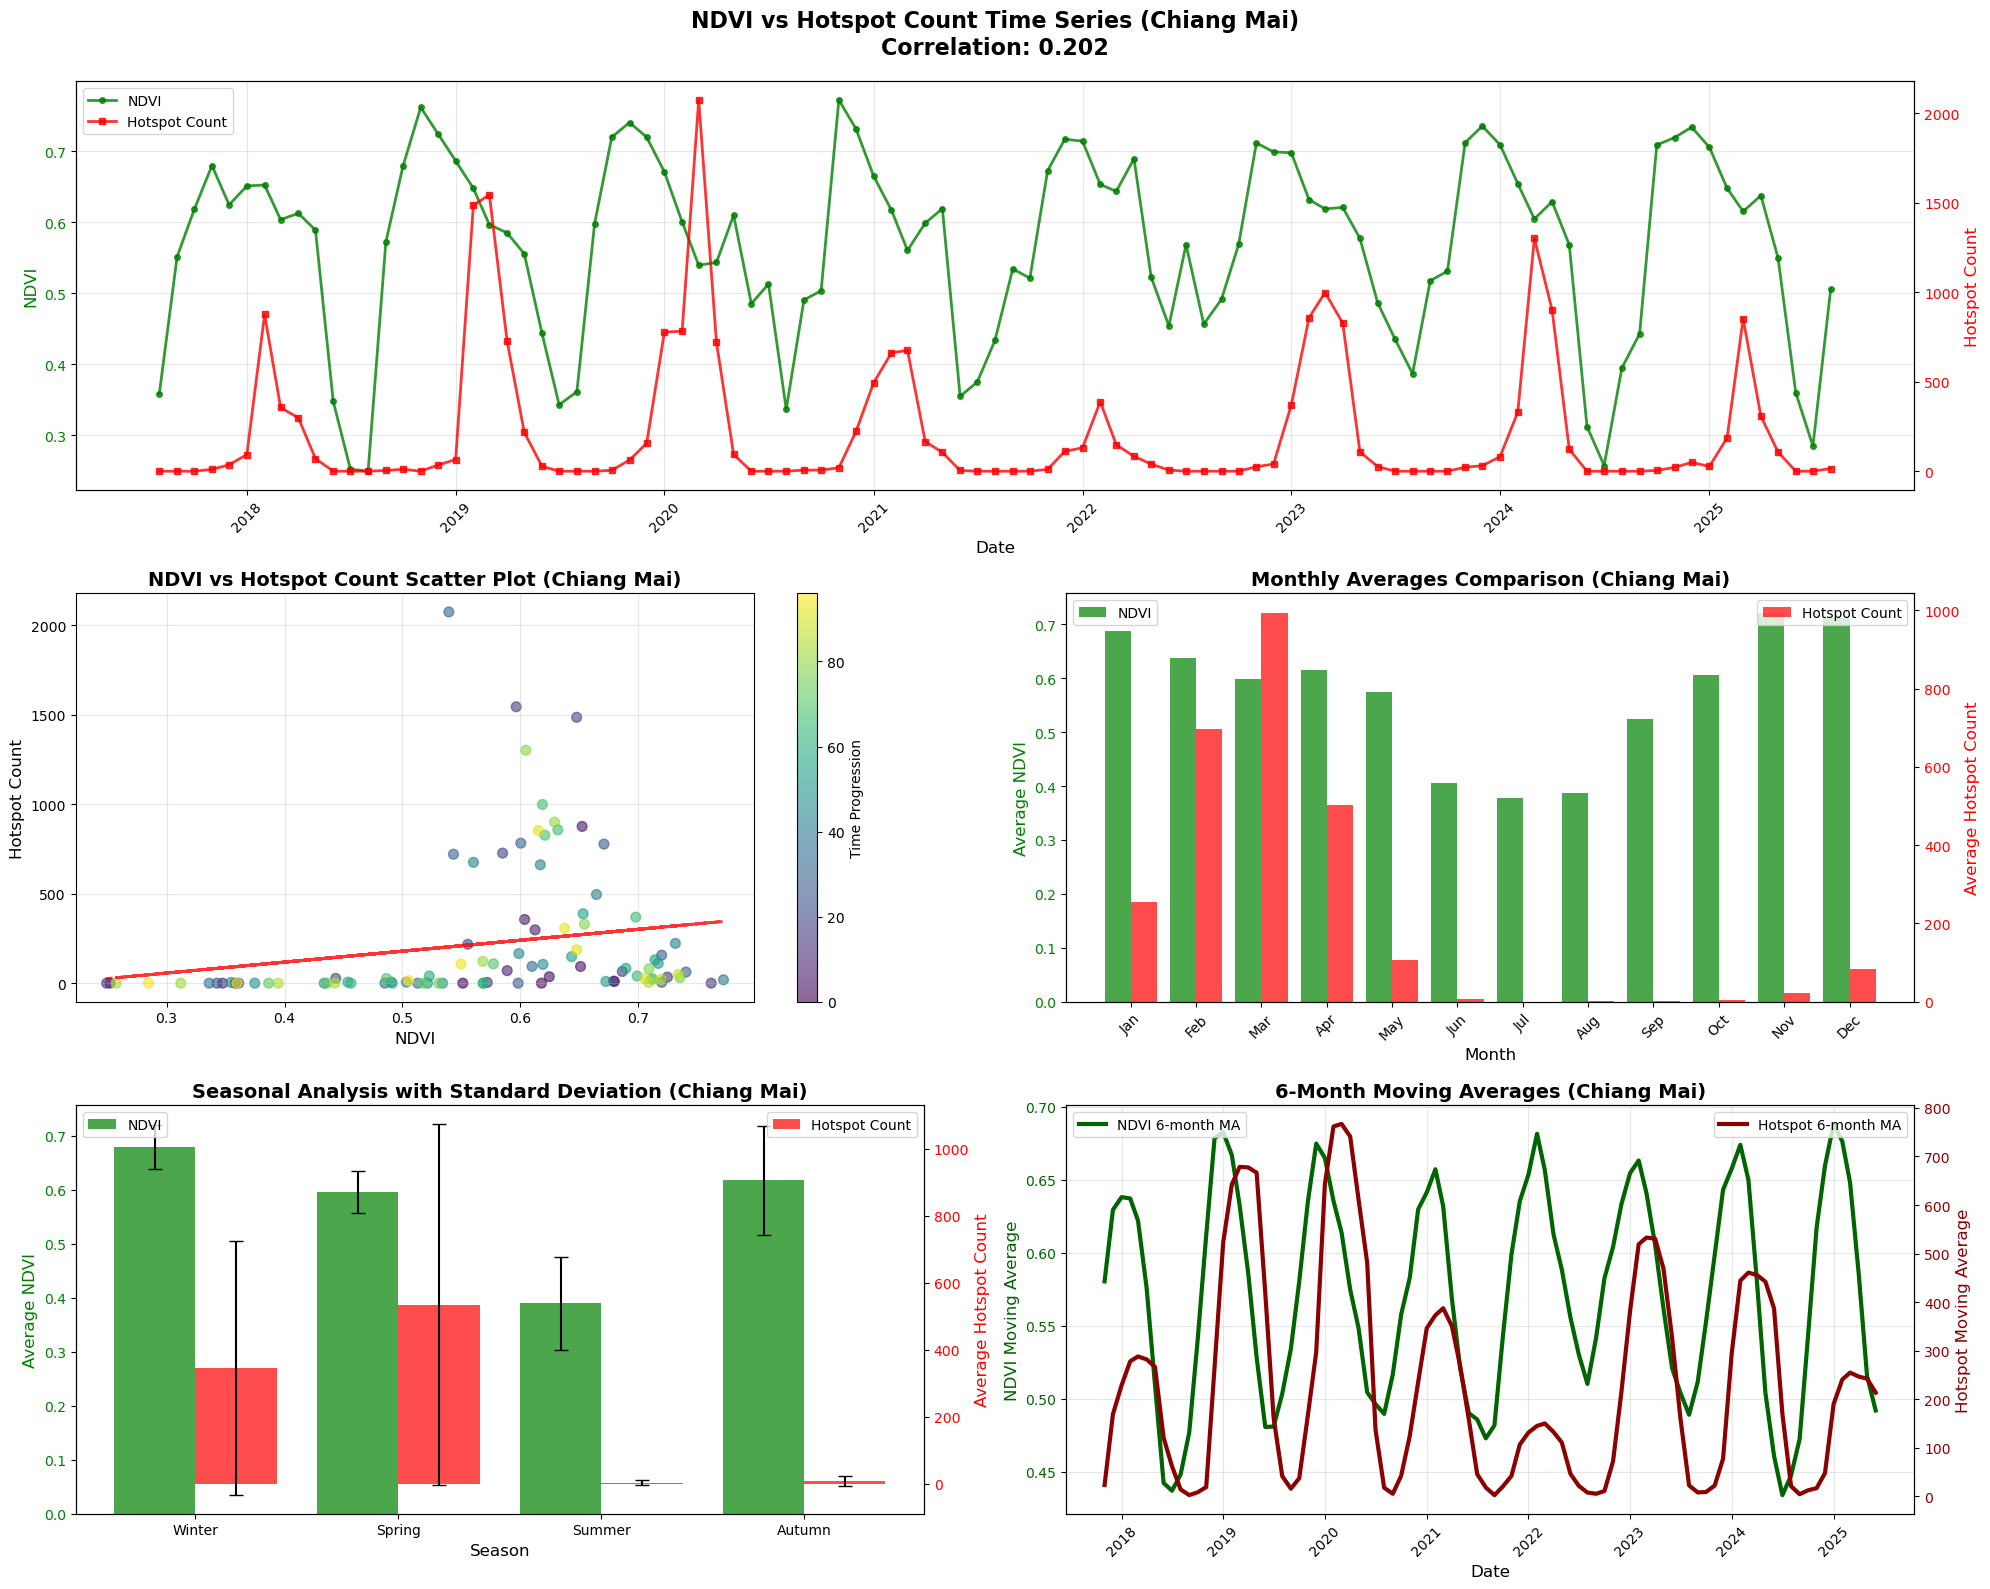


การวิเคราะห์ความสัมพันธ์ NDVI vs Hotspot Count
Pearson Correlation: 0.2024

Lag Correlation Analysis:
NDVI vs Hotspot (lag 1 months): 0.0814
NDVI vs Hotspot (lag 2 months): -0.1044
NDVI vs Hotspot (lag 3 months): -0.4278
NDVI vs Hotspot (lag 4 months): -0.6249
NDVI vs Hotspot (lag 5 months): -0.6062
NDVI vs Hotspot (lag 6 months): -0.3201

Seasonal Correlations:
Winter: -0.5877
Spring: -0.1290
Summer: 0.3686
Autumn: 0.5632
บันทึกกราฟ Yearly Comparison: Chiang Mai_yearly_comparison_analysis.png


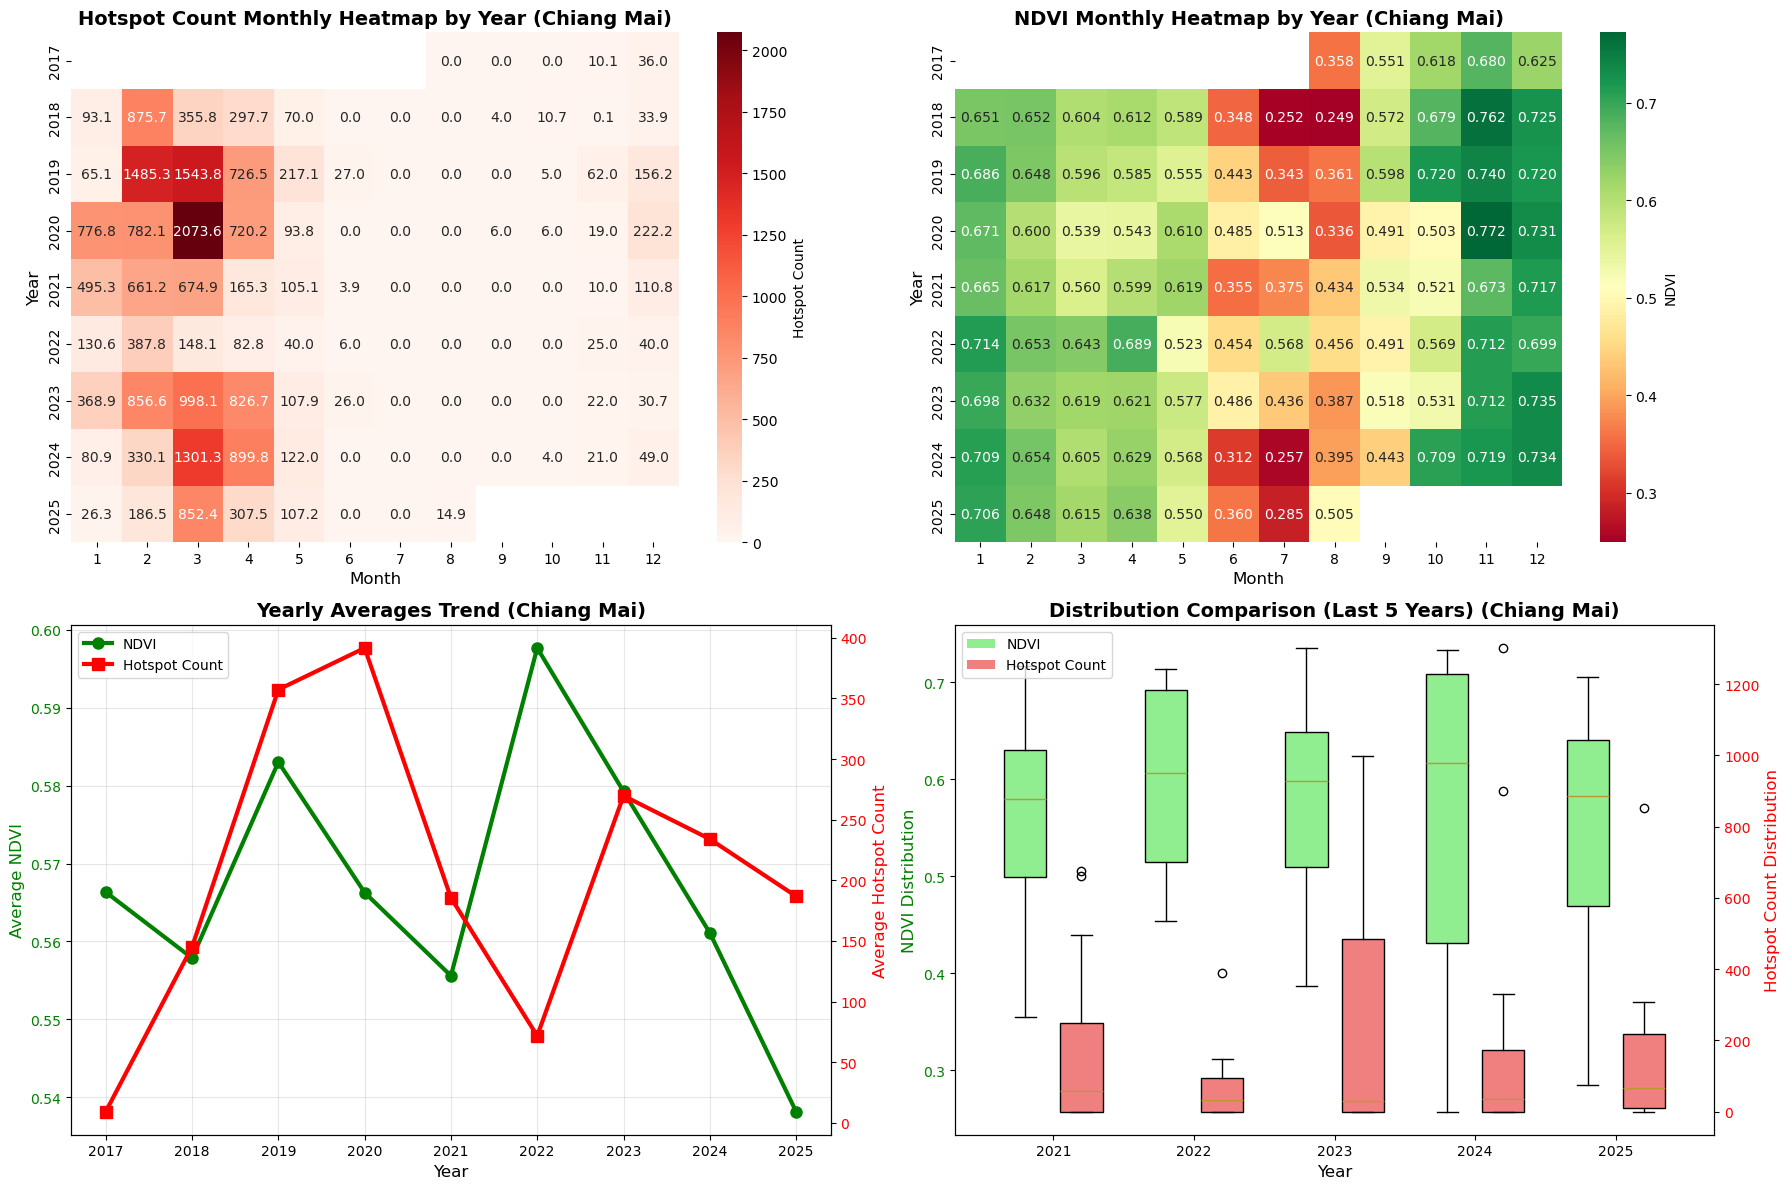


COMPREHENSIVE ANALYSIS REPORT: NDVI vs HOTSPOT COUNT

1. BASIC STATISTICS
----------------------------------------
            NDVI  hotspot_count
count  97.000000      97.000000
mean    0.568519     220.635254
std     0.131065     395.590047
min     0.249142       0.000000
25%     0.491416       0.000000
50%     0.598716      27.000000
75%     0.670847     217.149017
max     0.772230    2073.623535

2. CORRELATION ANALYSIS
----------------------------------------
Correlation Matrix:
                   NDVI  hotspot_count     month      year
NDVI           1.000000       0.202359 -0.003803 -0.017537
hotspot_count  0.202359       1.000000 -0.542251  0.004503
month         -0.003803      -0.542251  1.000000 -0.170163
year          -0.017537       0.004503 -0.170163  1.000000

Pearson Correlation Coefficient: 0.2024
P-value: 0.0468
Statistical Significance: Yes (α = 0.05)

3. SEASONAL ANALYSIS (SEA Climate)
----------------------------------------
Seasonal Statistics (SEA Climate):
     

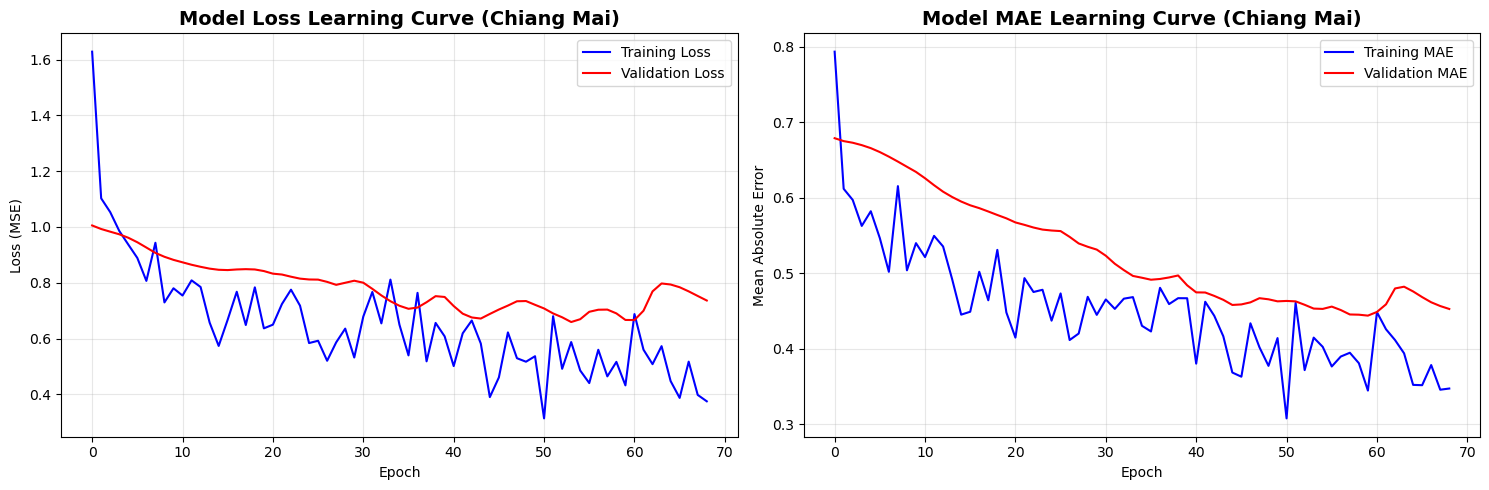

บันทึกกราฟ Learning Curve: learning_curve.png

กำลังดำเนินการประเมินแบบจำลองแบบครอบคลุม...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
ผลการประเมิน LSTM (เบื้องต้น):
LSTM - RMSE: 283.3122, MAE: 178.4042, R²: 0.4043

เริ่มการประเมินแบบครอบคลุมกับ Baseline Models...
การประเมินแบบจำลองแบบครอบคลุม (Comprehensive Model Evaluation)

1. การประเมิน Baseline Models
--------------------------------------------------
กำลังประเมิน Seasonal Naïve...
กำลังประเมิน Naïve with Drift...
กำลังประเมิน Moving Average...
กำลังประเมิน Exponential Smoothing...
ETS model ล้มเหลว: 'HoltWintersResults' object has no attribute 'get_prediction'
กำลังประเมิน ARIMA...
กำลังประเมิน SARIMA...


/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/si

กำลังประเมิน Auto-ARIMA...
pmdarima ไม่พร้อมใช้งาน ข้าม Auto-ARIMA model
เพิ่มผลการประเมิน LSTM...

กำลังสร้างแผนภูมิเปรียบเทียบโมเดล...


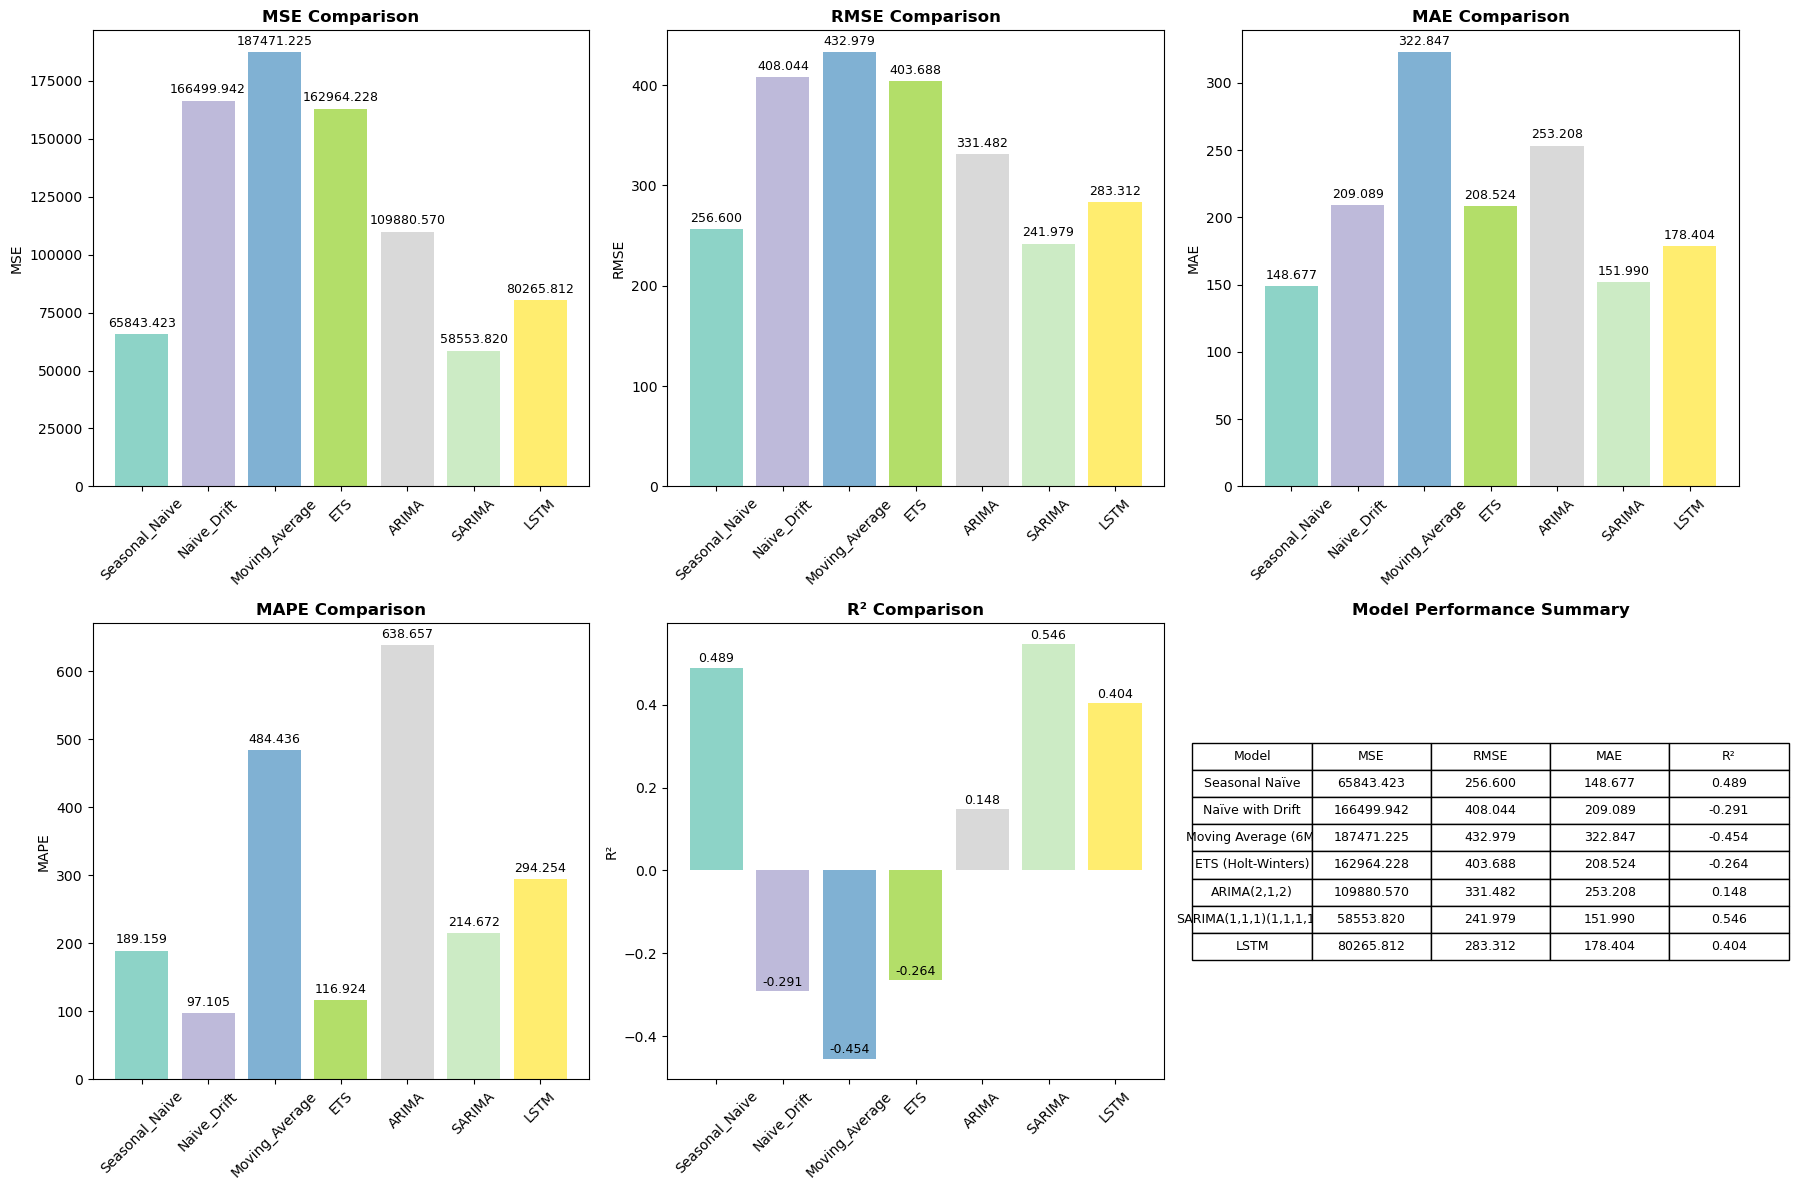

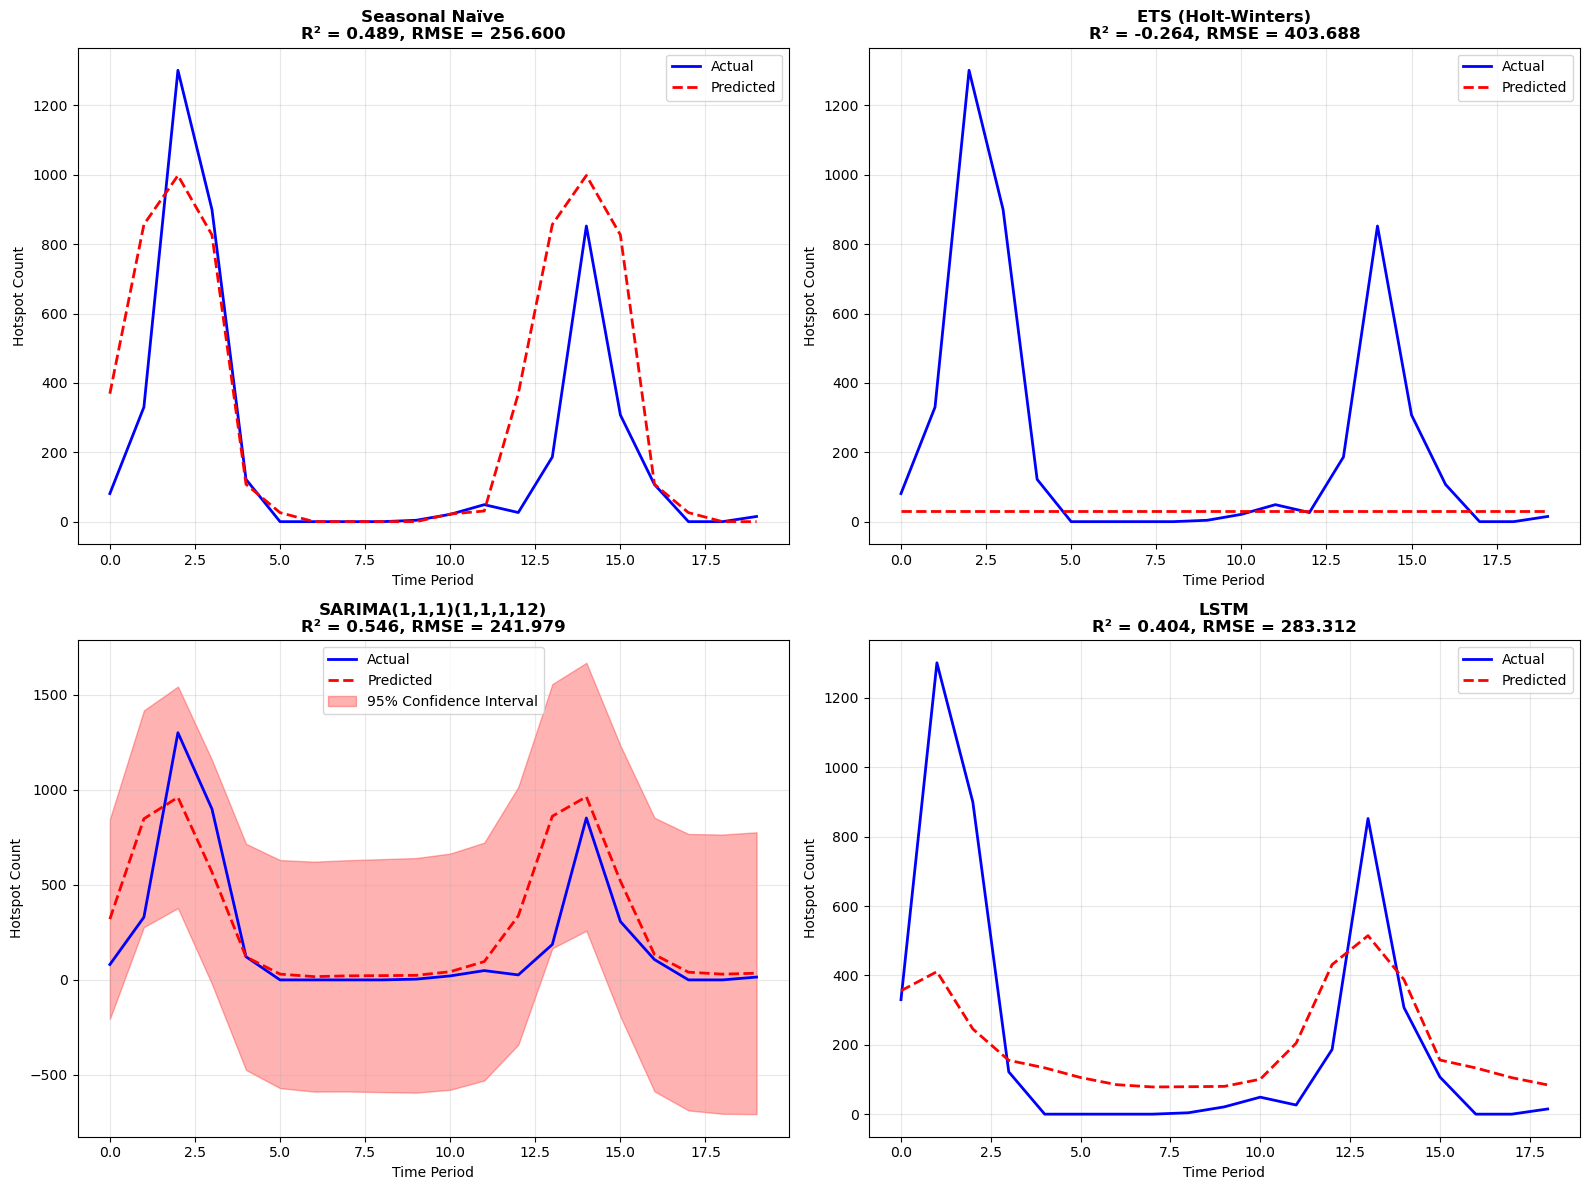


สรุปผลการประเมินโมเดล (Model Evaluation Summary)
Rank Model                MSE        RMSE       MAE        MAPE       R²        
--------------------------------------------------------------------------------
1    SARIMA(1,1,1)(1,1,1,12) 58553.8201 241.9790   151.9900   214.67%    0.5459    
2    Seasonal Naïve       65843.4232 256.5997   148.6767   189.16%    0.4894    
3    LSTM                 80265.8120 283.3122   178.4042   294.25%    0.4043    
4    ARIMA(2,1,2)         109880.5702 331.4824   253.2076   638.66%    0.1479    
5    ETS (Holt-Winters)   162964.2276 403.6883   208.5241   116.92%    -0.2638   
6    Naïve with Drift     166499.9416 408.0440   209.0885   97.11%     -0.2912   
7    Moving Average (6M)  187471.2252 432.9795   322.8468   484.44%    -0.4539   

🏆 โมเดลที่ดีที่สุด (ตาม RMSE): SARIMA(1,1,1)(1,1,1,12)
📊 อันดับของ LSTM: 3 จาก 7 โมเดล
⚠️  LSTM อันดับ 3 ควรพิจารณาปรับปรุงเพิ่มเติม

กำลังสร้างกราฟ Actual vs Predicted...


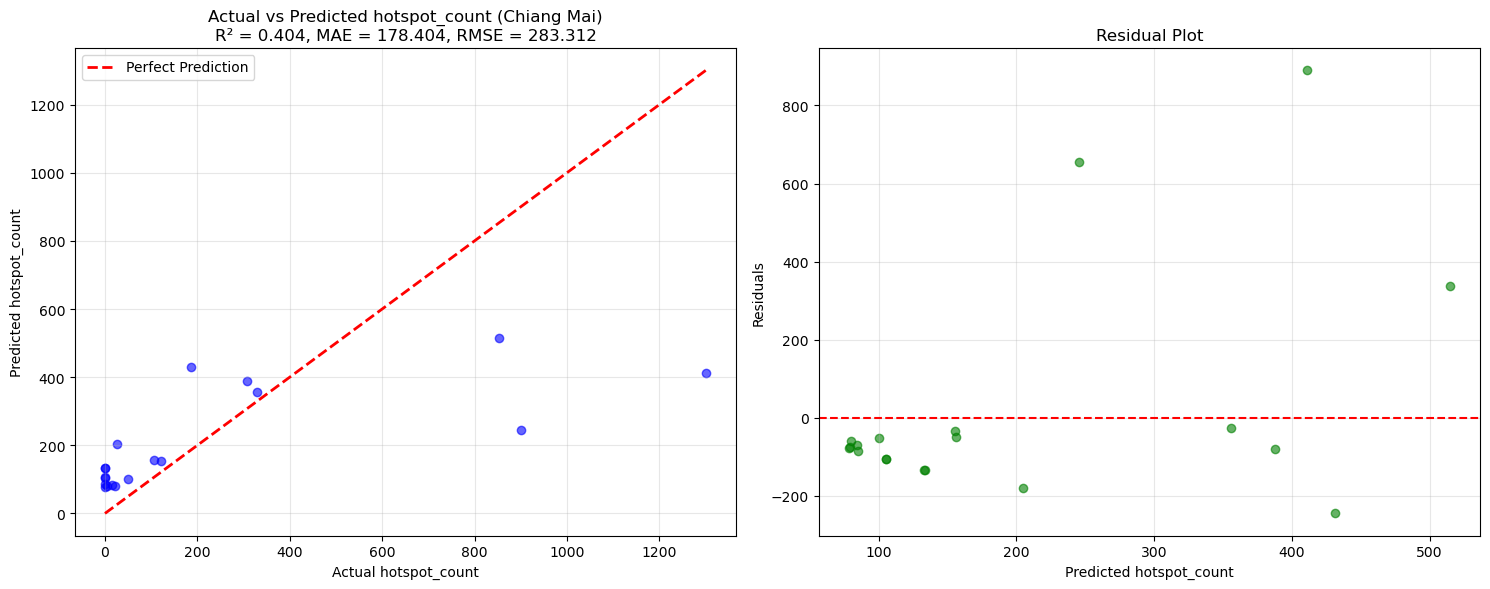

บันทึกกราฟ Actual vs Predicted: actual_vs_predicted.png

กำลังทำนาย 12 เดือนข้างหน้า...
การทำนายเสร็จสมบูรณ์!

กำลังคำนวดช่วงความเชื่อมั่นสำหรับการทำนาย...
ช่วงความเชื่อมั่น 80%: ±362.3
ช่วงความเชื่อมั่น 95%: ±553.9

กำลังสร้างตารางสรุปการทำนาย...

สรุปการทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า
      Date     Month  Year  Predicted_hotspot_count Risk_Level Season
2025-09-01 September  2025                     84.0  High Risk Summer
2025-10-01   October  2025                     80.0  High Risk Summer
2025-11-01  November  2025                     89.0  High Risk Summer
2025-12-01  December  2025                    108.0  High Risk Summer
2026-01-01   January  2026                    174.0  High Risk Summer
2026-02-01  February  2026                    317.0  High Risk Summer
2026-03-01     March  2026                    473.0  High Risk Summer
2026-04-01     April  2026                    282.0  High Risk Summer
2026-05-01       May  2026                    151.0  High Risk

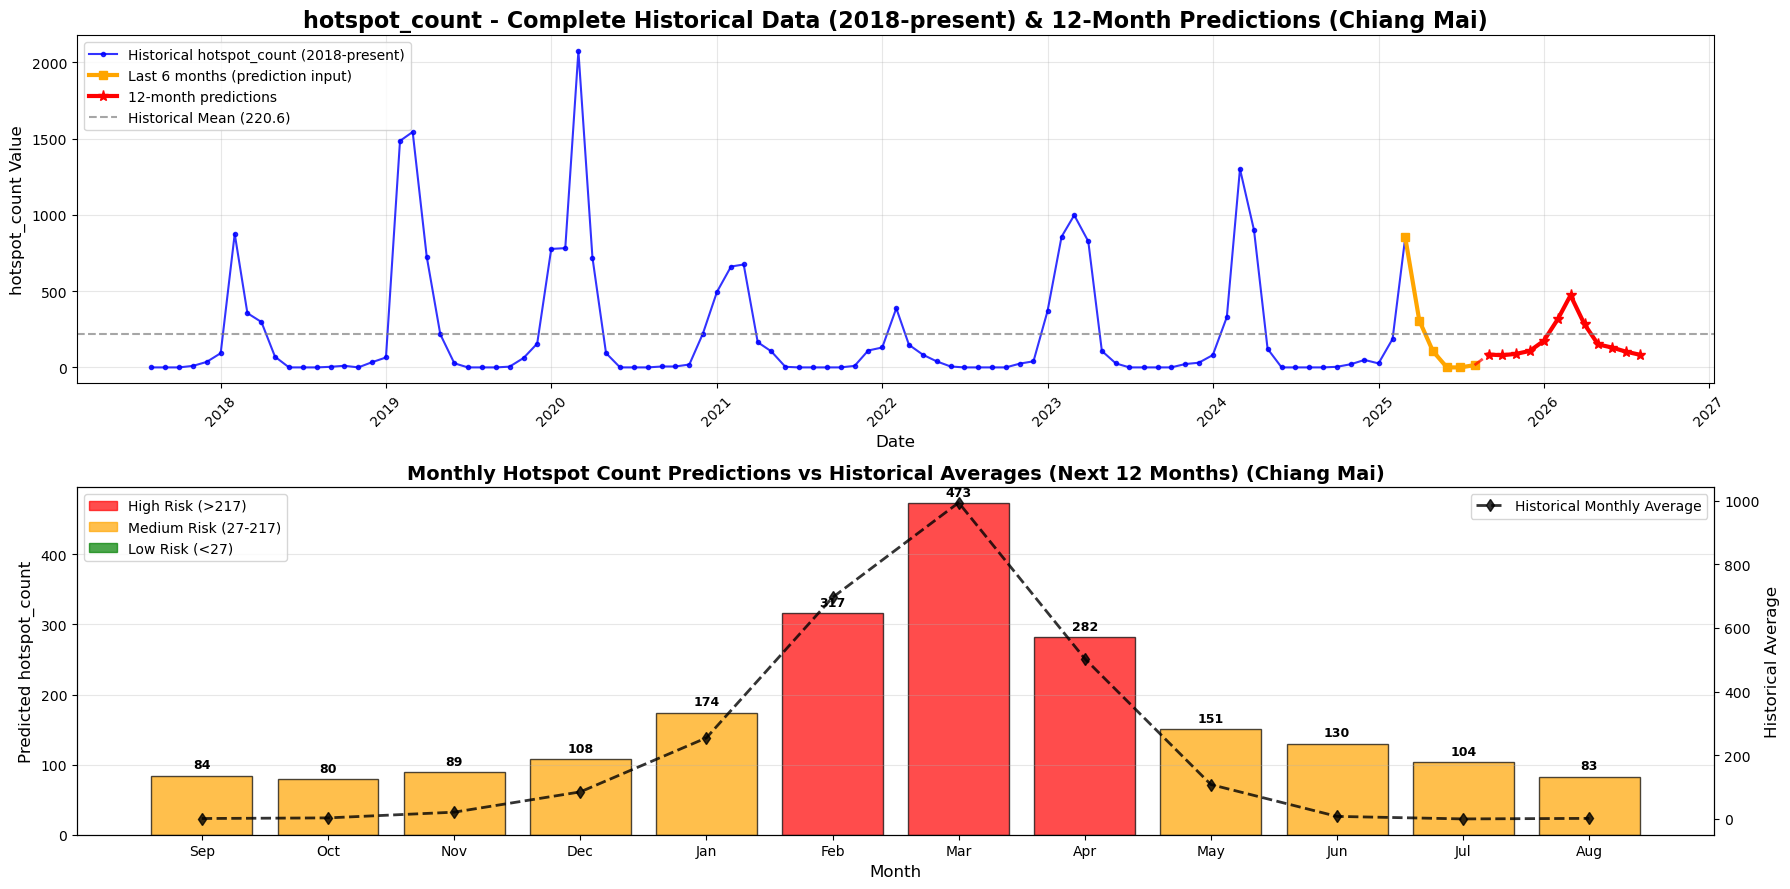

บันทึกกราฟทำนาย 12 เดือน: Chiang Mai_12_month_prediction.png

การเปรียบเทียบการทำนายกับค่าเฉลี่ยในอดีต:
Sep: ทำนาย 84, เฉลี่ยในอดีต 1.2, ต่าง +83.1 (+6646.5%) ↑ เพิ่มขึ้น
Oct: ทำนาย 80, เฉลี่ยในอดีต 3.2, ต่าง +76.6 (+2386.6%) ↑ เพิ่มขึ้น
Nov: ทำนาย 89, เฉลี่ยในอดีต 21.2, ต่าง +67.8 (+320.3%) ↑ เพิ่มขึ้น
Dec: ทำนาย 108, เฉลี่ยในอดีต 84.9, ต่าง +23.2 (+27.3%) ↑ เพิ่มขึ้น
Jan: ทำนาย 174, เฉลี่ยในอดีต 254.6, ต่าง -80.5 (-31.6%) ↓ ลดลง
Feb: ทำนาย 317, เฉลี่ยในอดีต 695.7, ต่าง -378.9 (-54.5%) ↓ ลดลง
Mar: ทำนาย 473, เฉลี่ยในอดีต 993.5, ต่าง -520.8 (-52.4%) ↓ ลดลง
Apr: ทำนาย 282, เฉลี่ยในอดีต 503.3, ต่าง -221.6 (-44.0%) ↓ ลดลง
May: ทำนาย 151, เฉลี่ยในอดีต 107.9, ต่าง +42.8 (+39.7%) ↑ เพิ่มขึ้น
Jun: ทำนาย 130, เฉลี่ยในอดีต 7.9, ต่าง +122.2 (+1554.2%) ↑ เพิ่มขึ้น
Jul: ทำนาย 104, เฉลี่ยในอดีต 0.0, ต่าง +103.5 (+0.0%) ↑ เพิ่มขึ้น
Aug: ทำนาย 83, เฉลี่ยในอดีต 1.7, ต่าง +81.4 (+4911.0%) ↑ เพิ่มขึ้น

การวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนเสร็จสมบูรณ์!
ไฟล์ที่สร้าง:
📊 การวิเคราะห์:
  - ndvi_hotspo

In [4]:
    
# Updated main function to use temperature filtering
def main():
    print("เริ่มการวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนสำหรับ 12 เดือนข้างหน้า (พร้อมการกรอง T21)")
    print("="*80)

    # กำหนดช่วงเวลาข้อมูล
    start_date = '2017-08-01'
    end_date = '2025-08-31'
    
    # พารามิเตอร์สำหรับการกรอง hotspot 300-310k, 310-320k, >320k 
    TEMP_MIN = 310  # Kelvin - ปรับได้ตามต้องการ
    TEMP_MAX = 320  # Kelvin - ปรับได้ตามต้องการ
    USE_ALL_HOTSPOTS = False  # True = ใช้ T21 > 0, False = ใช้ช่วงอุณหภูมิ
    
    print(f"การตั้งค่าการกรอง hotspot:")
    if USE_ALL_HOTSPOTS:
        print("- ใช้ทุกจุดความร้อน (T21 > 0)")
    else:
        print(f"- ใช้ช่วงอุณหภูมิ: {TEMP_MIN}K ≤ T21 < {TEMP_MAX}K")
    print()

    print("กำลังดึงข้อมูล NDVI รายเดือนจาก Google Earth Engine...")
    ndvi_data = get_monthly_ndvi(start_date, end_date, study_area)

    print("กำลังดึงข้อมูล Hotspot รายเดือนพร้อมการกรอง T21...")
    hotspot_data = get_monthly_hotspots(
        start_date, end_date, study_area, 
        temp_min=TEMP_MIN, 
        temp_max=TEMP_MAX,
        all_hotspots=USE_ALL_HOTSPOTS
    )

    if ndvi_data is not None and hotspot_data is not None:
        print(f"จำนวนเดือนที่มีข้อมูล NDVI: {ndvi_data.size().getInfo()}")
        print(f"จำนวนเดือนที่มีข้อมูล Hotspot: {hotspot_data.size().getInfo()}")

        print("กำลังสร้างชุดข้อมูลรวม...")
        dataset = create_monthly_dataset_with_filtered_hotspots(ndvi_data, hotspot_data, study_area)

        if dataset is not None:
            print("กำลังแปลงข้อมูลเป็น DataFrame...")
            df = fc_to_df(dataset)
            print(f"จำนวนข้อมูลใน DataFrame: {len(df)} เดือน")

            if not df.empty and len(df) > 24:
                print("ตัวอย่างข้อมูล:")
                print(df.head(10))
                print(f"\nช่วงข้อมูล: {df['date'].min()} ถึง {df['date'].max()}")
                print(f"สถิติพื้นฐาน hotspot count:")
                print(f"- ค่าเฉลี่ย: {df['hotspot_count'].mean():.2f}")
                print(f"- ค่าสูงสุด: {df['hotspot_count'].max():.0f}")
                print(f"- ค่าต่ำสุด: {df['hotspot_count'].min():.0f}")
                print(f"- ส่วนเบียงเบนมาตรฐาน: {df['hotspot_count'].std():.2f}")

                # ส่วนใหม่: การวิเคราะห์ Time Series ขั้นสูง
                print("\n" + "="*60)
                print("กำลังสร้างกราฟการวิเคราะห์ Time Series ขั้นสูง...")
                print("="*60)

                # 1. Comprehensive time series analysis
                plot_ndvi_hotspot_time_series(df)

                # 2. Yearly comparison analysis  
                plot_yearly_comparison(df)

                # 3. Statistical analysis report
                analysis_results = create_comprehensive_analysis_report(df)

                # ส่วนเดิม: การสร้างแบบจำลอง LSTM (ปรับปรุง)
                print("\n" + "="*60)
                print("กำลังดำเนินการสร้างแบบจำลองและทำนาย...")
                print("="*60)
                
                print("กำลังเตรียมข้อมูลสำหรับการสร้างแบบจำลอง...")
                try:
                    X, y, scaler_x, scaler_y, df_cleaned = prepare_monthly_training_data(
                        df, sequence_length=6, target_column='hotspot_count'
                    )
                    print(f"ข้อมูลที่เตรียม: X.shape = {X.shape}, y.shape = {y.shape}")

                    # แบ่งข้อมูลสำหรับการประเมิน
                    split_idx = int(len(X) * 0.8)
                    X_train, X_test = X[:split_idx], X[split_idx:]
                    y_train, y_test = y[:split_idx], y[split_idx:]

                    print(f"ข้อมูลสอน: {X_train.shape}, ข้อมูลทดสอบ: {X_test.shape}")

                    # สร้างและสอนแบบจำลอง
                    print("กำลังสร้างแบบจำลอง LSTM...")
                    model = create_monthly_lstm_model(X_train.shape[1], X_train.shape[2])

                    if model is None:
                        print("ไม่สามารถสร้างแบบจำลองได้ กรุณาตรวจสอบการติดตั้ง TensorFlow")
                        return

                    print("กำลังสอนแบบจำลอง...")

                    # เพิ่ม callbacks สำหรับการสอนที่ดีขึ้น
                    try:
                        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

                        early_stopping = EarlyStopping(
                            monitor='val_loss',
                            patience=15,
                            restore_best_weights=True,
                            verbose=1
                        )

                        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss',
                            factor=0.5,
                            patience=10,
                            min_lr=1e-7,
                            verbose=1
                        )

                        callbacks = [early_stopping, reduce_lr]
                    except ImportError:
                        callbacks = []

                    history = model.fit(
                        X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_test, y_test) if len(X_test) > 0 else None,
                        callbacks=callbacks,
                        verbose=0
                    )

                    # ส่วนเดิม: กราฟ Learning Curve
                    print("\nกำลังสร้างกราฟ Learning Curve...")
                    plot_learning_curve(history)

                    # ส่วนใหม่: การประเมินแบบครอบคลุม
                    if len(X_test) > 0:
                        print("\n" + "="*60)
                        print("กำลังดำเนินการประเมินแบบจำลองแบบครอบคลุม...")
                        print("="*60)
                        
                        # ทำนายด้วย LSTM
                        y_pred = model.predict(X_test)
                        y_pred_rescaled = scaler_y.inverse_transform(y_pred).flatten()
                        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

                        print("ผลการประเมิน LSTM (เบื้องต้น):")
                        lstm_mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
                        lstm_rmse = np.sqrt(lstm_mse)
                        lstm_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
                        lstm_r2 = r2_score(y_test_rescaled, y_pred_rescaled)
                        
                        print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, R²: {lstm_r2:.4f}")

                        # การประเมินแบบครอบคลุมใหม่
                        print("\nเริ่มการประเมินแบบครอบคลุมกับ Baseline Models...")
                        
                        # เรียกใช้ฟังก์ชันประเมินแบบครอบคลุม
                        results, prediction_intervals = comprehensive_model_evaluation(
                            df=df_cleaned, 
                            lstm_predictions=y_pred_rescaled,
                            lstm_actuals=y_test_rescaled,
                            target_column='hotspot_count',
                            siteName=siteName
                        )

                        # สร้างแผนภูมิเปรียบเทียบ
                        print("\nกำลังสร้างแผนภูมิเปรียบเทียบโมเดล...")
                        plot_model_comparison_comprehensive(results, prediction_intervals, siteName)

                        # พิมพ์สรุปผล
                        print_model_summary(results)

                        # การสร้างกราฟเปรียบเทียบเดิม
                        print("\nกำลังสร้างกราฟ Actual vs Predicted...")
                        plot_actual_vs_predicted(
                            y_test_rescaled,
                            y_pred_rescaled,
                            target_column='hotspot_count'
                        )

                    # การทำนาย 12 เดือนข้างหน้า (ปรับปรุง)
                    print("\n" + "="*60)
                    print("กำลังทำนาย 12 เดือนข้างหน้า...")
                    print("="*60)
                    
                    last_sequence = X[-1:]
                    predictions, prediction_dates = predict_next_12_months(
                        model, last_sequence, scaler_x, scaler_y, df_cleaned, sequence_length=6
                    )

                    print("การทำนายเสร็จสมบูรณ์!")

                    # การสร้าง Prediction Intervals สำหรับการทำนาย 12 เดือน
                    print("\nกำลังคำนวดช่วงความเชื่อมั่นสำหรับการทำนาย...")
                    
                    # คำนวด prediction intervals แบบง่าย (จาก residuals)
                    if len(X_test) > 0:
                        residuals = y_test_rescaled - y_pred_rescaled
                        residual_std = np.std(residuals)
                        
                        # สร้าง confidence intervals
                        confidence_80 = 1.282 * residual_std  # 80% CI
                        confidence_95 = 1.96 * residual_std   # 95% CI
                        
                        prediction_intervals_12m = {
                            '80%': {
                                'lower': np.array(predictions) - confidence_80,
                                'upper': np.array(predictions) + confidence_80
                            },
                            '95%': {
                                'lower': np.array(predictions) - confidence_95,
                                'upper': np.array(predictions) + confidence_95
                            }
                        }
                        
                        print(f"ช่วงความเชื่อมั่น 80%: ±{confidence_80:.1f}")
                        print(f"ช่วงความเชื่อมั่น 95%: ±{confidence_95:.1f}")
                    else:
                        prediction_intervals_12m = {}

                    # สร้างตารางสรุป
                    print("\nกำลังสร้างตารางสรุปการทำนาย...")
                    pred_summary_df = create_prediction_summary_table(
                        predictions, prediction_dates, target_column='hotspot_count'
                    )

                    # ================================
                    # การสร้างกราฟทำนาย 12 เดือน (ปรับปรุง)
                    # ================================
                    print("\nกำลังสร้างกราฟการทำนาย 12 เดือน...")
                    plot_12_month_prediction(df_cleaned, predictions, prediction_dates, target_column='hotspot_count')

                    # ================================
                    # สรุปไฟล์ที่สร้าง
                    # ================================
                    print("\n" + "="*80)
                    print("การวิเคราะห์และทำนาย HOTSPOT COUNT รายเดือนเสร็จสมบูรณ์!")
                    print("="*80)
                    print("ไฟล์ที่สร้าง:")
                    print("📊 การวิเคราะห์:")
                    print("  - ndvi_hotspot_time_series_analysis.png: การวิเคราะห์ time series ขั้นสูง")
                    print("  - yearly_comparison_analysis.png: การเปรียบเทียบรายปี")
                    print("  - ndvi_hotspot_analysis_report.txt: รายงานการวิเคราะห์")
                    print("📈 การประเมินโมเดล:")
                    print("  - model_metrics_comparison.png: เปรียบเทียบ metrics โมเดลต่างๆ")
                    print("  - predictions_with_intervals.png: การทำนายพร้อมช่วงความเชื่อมั่น")
                    print("  - learning_curve.png: กราฟ Learning Curve")
                    print("  - actual_vs_predicted.png: กราฟ Actual vs Predicted")
                    print("🔮 การทำนาย:")
                    print("  - 12_month_prediction.png: กราฟการทำนาย 12 เดือน")
                    print("  - 12_month_hotspot_predictions.csv: ตารางผลการทำนาย")
                    print(f"\n🎯 การกรอง T21: {TEMP_MIN}K ≤ T21 < {TEMP_MAX}K" if not USE_ALL_HOTSPOTS else "\n🎯 การกรอง T21: ทุกจุดความร้อน (T21 > 0)")
                    print("🎯 สำคัญ: ตรวจสอบอันดับของ LSTM ในการเปรียบเทียบโมเดล")
                    print("   - หาก LSTM อันดับต้นๆ: โมเดลมีประสิทธิภาพดี")
                    print("   - หาก LSTM อันดับท้ายๆ: ควรปรับปรุงโมเดลหรือใช้โมเดลง่ายกว่า")

                except Exception as e:
                    print(f"เกิดข้อผิดพลาดในการเตรียมข้อมูล: {e}")
                    import traceback
                    print("รายละเอียดข้อผิดพลาด:")
                    traceback.print_exc()
            else:
                print("ข้อมูลไม่เพียงพอสำหรับการสร้างแบบจำลอง (ต้องการอย่างน้อย 24 เดือน)")
        else:
            print("ไม่สามารถสร้างชุดข้อมูลได้")
    else:
        print("ไม่สามารถดึงข้อมูล NDVI หรือ Hotspot ได้")



if __name__ == "__main__":
    main()